In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns

from datetime import datetime
from plotly.subplots import make_subplots
from market_analyzer import MarketAnalyzer, RiskAnalyzer, MarketVisualizer, RegimeAnalyzer, LeadLagAnalyzer, PatternRecognition, VolumePatternType, VolumePattern
from typing import Dict, List, Tuple

plt.style.use('dark_background')

In [12]:
# Create date range
dates = pd.date_range(start='2023-01-01', end='2024-12-31', freq='B')

# Head and Shoulders pattern (90 days total)
h_and_s = np.concatenate([
    np.linspace(100, 110, 15),  # Left shoulder up
    np.linspace(110, 100, 15),  # Left shoulder down
    np.linspace(100, 120, 15),  # Head up
    np.linspace(120, 100, 15),  # Head down
    np.linspace(100, 111, 15),  # Right shoulder up (within 2% of left)
    np.linspace(111, 100, 15)   # Right shoulder down
])

# Double Bottom pattern (60 days total)
double_bottom = np.concatenate([
    np.linspace(100, 80, 15),   # First bottom down
    np.linspace(80, 95, 15),    # Rise between bottoms
    np.linspace(95, 81, 15),    # Second bottom (within 2% of first)
    np.linspace(81, 100, 15)    # Final rise
])

# Create base price data
prices = np.concatenate([
    h_and_s,                    # First 90 days: H&S pattern
    double_bottom,              # Next 60 days: Double bottom
    np.full(len(dates)-150, 100)  # Fill remaining days with stable price
])

# Create volume data with clear divergence
volumes = np.concatenate([
    np.linspace(1e6, 1e6, 90),      # Stable volume for H&S
    np.linspace(1e6, 1e6, 60),      # Stable volume for double bottom
    np.linspace(2e6, 1e6, 50),      # Declining volume despite stable price
    np.full(len(dates)-200, 1e6)    # Fill remaining days
])


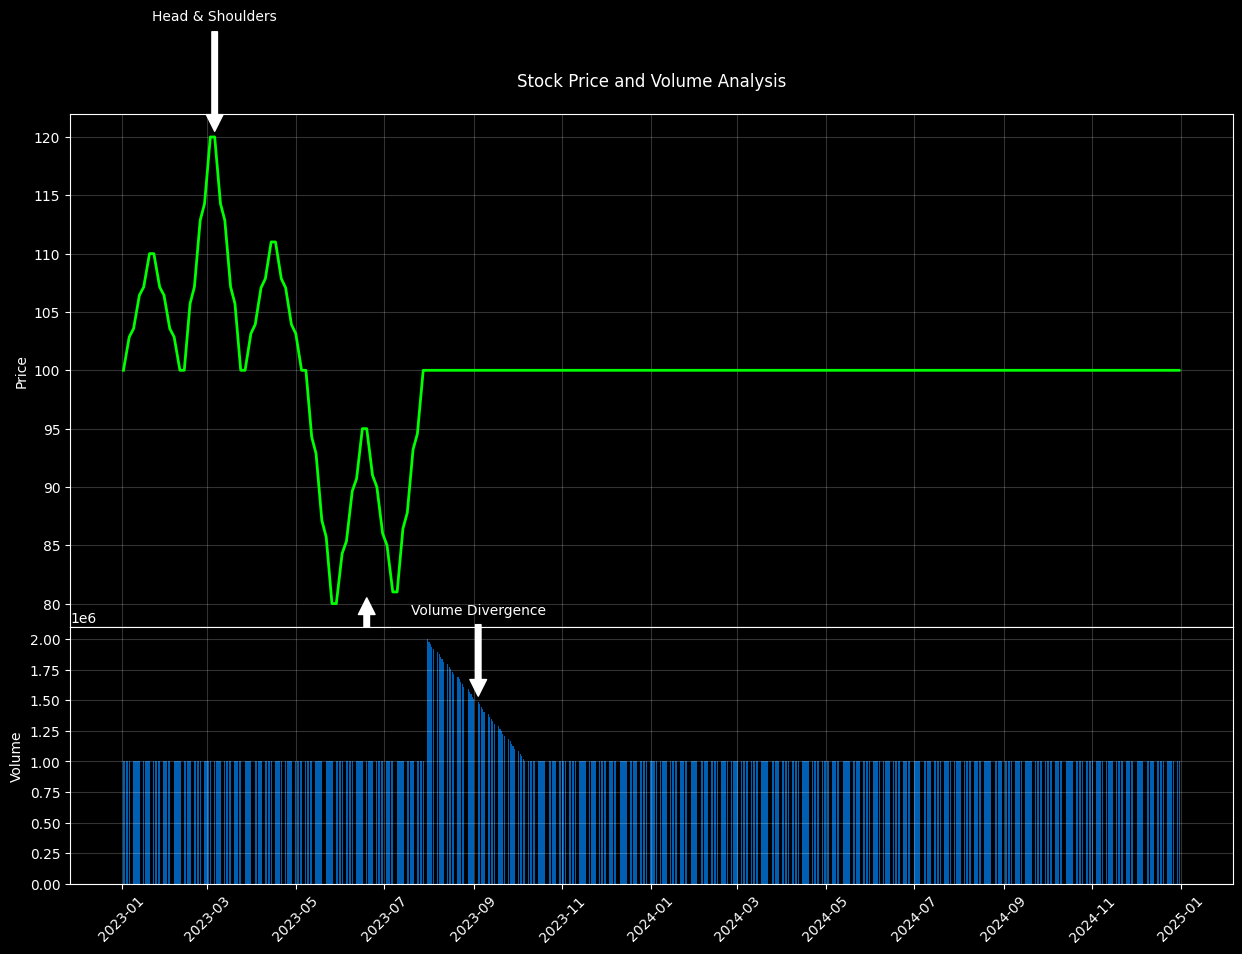


Pattern Statistics:

Head & Shoulders Pattern (first 90 days):
count     90.000000
mean     106.833333
std        5.004813
min      100.000000
25%      102.857143
50%      106.285714
75%      109.428571
max      120.000000
Name: price, dtype: float64

Double Bottom Pattern (next 60 days):
count     60.000000
mean      89.000000
std        5.502036
min       80.000000
25%       84.285714
50%       88.785714
75%       93.053571
max      100.000000
Name: price, dtype: float64

Volume Statistics:
count    5.220000e+02
mean     1.047893e+06
std      1.732572e+05
min      1.000000e+06
25%      1.000000e+06
50%      1.000000e+06
75%      1.000000e+06
max      2.000000e+06
Name: volume, dtype: float64


In [13]:
# Create DataFrame
df = pd.DataFrame({
    'date': dates[:len(prices)],
    'price': prices,
    'volume': volumes
})

# Create the visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1], sharex=True)
plt.subplots_adjust(hspace=0)

# Plot price
ax1.plot(df['date'], df['price'], color='#00ff00', linewidth=2)
ax1.set_title('Stock Price and Volume Analysis', pad=20)
ax1.set_ylabel('Price')
ax1.grid(True, alpha=0.2)

# Add pattern annotations
ax1.annotate('Head & Shoulders', 
            xy=(df['date'][45], 120),
            xytext=(df['date'][45], 130),
            arrowprops=dict(facecolor='white', shrink=0.05),
            ha='center')

ax1.annotate('Double Bottom', 
            xy=(df['date'][120], 81),
            xytext=(df['date'][120], 70),
            arrowprops=dict(facecolor='white', shrink=0.05),
            ha='center')

# Plot volume
ax2.bar(df['date'], df['volume'], color='#0088ff', alpha=0.7)
ax2.set_ylabel('Volume')
ax2.grid(True, alpha=0.2)

# Format x-axis
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Add volume divergence annotation
ax2.annotate('Volume Divergence', 
            xy=(df['date'][175], 1.5e6),
            xytext=(df['date'][175], 2.2e6),
            arrowprops=dict(facecolor='white', shrink=0.05),
            ha='center')

plt.show()

# You might also want to see some basic statistics about the patterns
print("\nPattern Statistics:")
print("\nHead & Shoulders Pattern (first 90 days):")
print(df.iloc[:90]['price'].describe())
print("\nDouble Bottom Pattern (next 60 days):")
print(df.iloc[90:150]['price'].describe())
print("\nVolume Statistics:")
print(df['volume'].describe())

In [14]:
pattern_detector = PatternRecognition(pd.Series(prices), pd.Series(volumes))

In [15]:
patterns_hs = pattern_detector.detect_head_and_shoulders()

In [16]:
patterns_hs

[TechnicalPattern(pattern_type='HEAD_AND_SHOULDERS', start_idx=14, end_idx=74, price_range=(29.0, 44.0), failure_reasons=None, specific_points=None, volume_range=None, sub_classification=None, confidence=nan)]

In [17]:
patterns_db = pattern_detector.detect_double_bottom()

In [18]:
patterns_db

[TechnicalPattern(pattern_type='DOUBLE_BOTTOM', start_idx=29, end_idx=59, price_range=(100.0, 120.0), failure_reasons=None, specific_points=None, volume_range=None, sub_classification=None, confidence=0.7),
 TechnicalPattern(pattern_type='DOUBLE_BOTTOM', start_idx=104, end_idx=134, price_range=(80.0, 95.0), failure_reasons=None, specific_points=None, volume_range=None, sub_classification=None, confidence=0.7)]

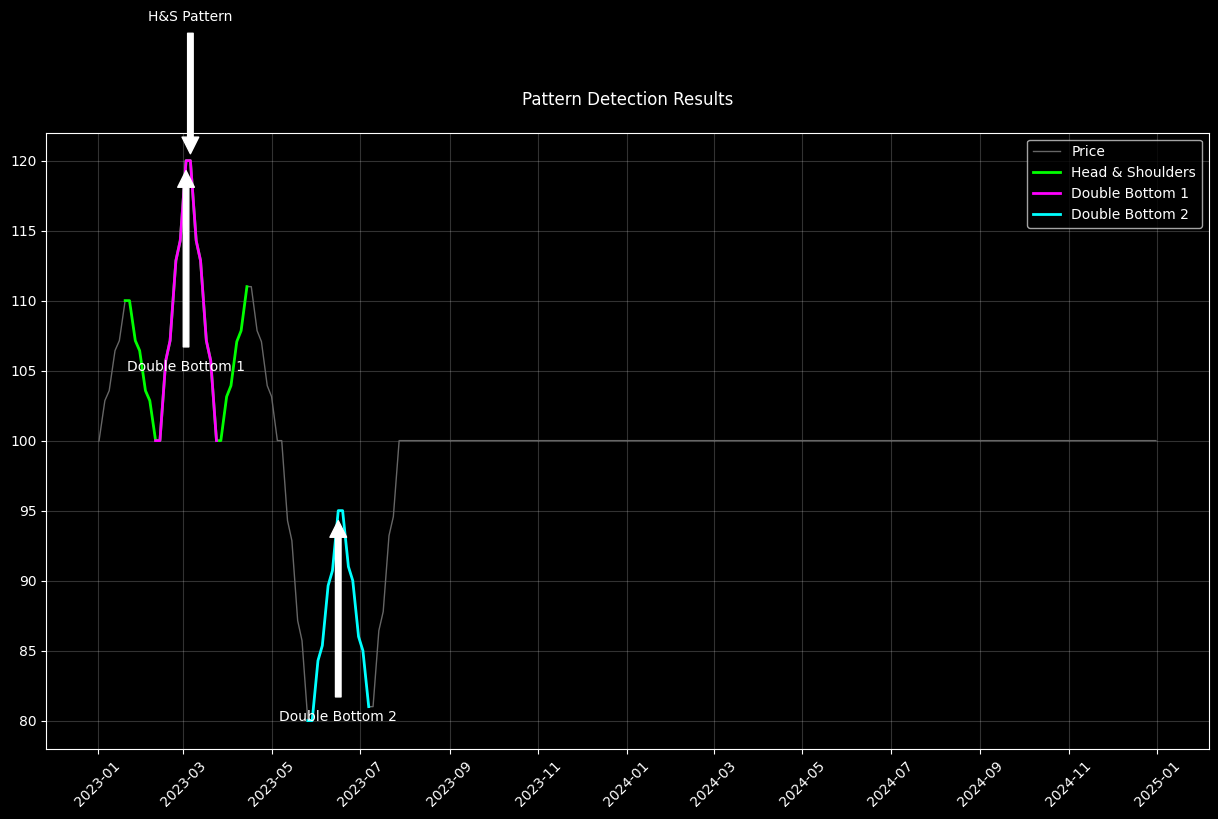

In [19]:
# Create figure for pattern detection
fig, ax = plt.subplots(figsize=(15, 8))
plt.title('Pattern Detection Results', pad=20)

# Plot base price
ax.plot(df['date'], df['price'], color='#666666', linewidth=1, label='Price')

# Highlight Head and Shoulders pattern
h_and_s_mask = (df.index >= 14) & (df.index <= 74)
ax.plot(df.loc[h_and_s_mask, 'date'], 
        df.loc[h_and_s_mask, 'price'], 
        color='#00ff00', 
        linewidth=2,
        label='Head & Shoulders')

# Highlight Double Bottom patterns
db_masks = [(29, 59), (104, 134)]
for i, (start, end) in enumerate(db_masks):
    mask = (df.index >= start) & (df.index <= end)
    ax.plot(df.loc[mask, 'date'], 
            df.loc[mask, 'price'], 
            color='#ff00ff' if i == 0 else '#00ffff', 
            linewidth=2,
            label=f'Double Bottom {i+1}')

# Add annotations
ax.annotate('H&S Pattern', 
           xy=(df['date'][45], 120),
           xytext=(df['date'][45], 130),
           arrowprops=dict(facecolor='white', shrink=0.05),
           ha='center')

for i, (start, end) in enumerate(db_masks):
    mid_idx = start + (end - start) // 2
    ax.annotate(f'Double Bottom {i+1}', 
                xy=(df['date'][mid_idx], df['price'][mid_idx]),
                xytext=(df['date'][mid_idx], df['price'][mid_idx] - 15),
                arrowprops=dict(facecolor='white', shrink=0.05),
                ha='center')

ax.grid(True, alpha=0.2)
ax.legend()

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.show()



In [20]:
# Volume-Price patterns

def generate_pattern_sequence(pattern_type: VolumePatternType, length: int, 
                            noise_level: float = 0.0) -> Tuple[pd.Series, pd.Series]:
    """Generate price and volume series for a specific pattern type."""
    
    # Base parameters
    price_change = 0.003  # Above min_price_change
    volume_change = 0.02  # Above min_volume_change
    
    # Initialize with starting values
    prices = [100.0]
    volumes = [1000.0]
    
    for i in range(length-1):
        # Add noise
        price_noise = np.random.normal(0, noise_level * price_change)
        volume_noise = np.random.normal(0, noise_level * volume_change)
        
        if pattern_type == VolumePatternType.DIVERGENCE:
            # Price up, volume down
            new_price = prices[-1] * (1 + price_change + price_noise)
            new_volume = volumes[-1] * (1 - volume_change + volume_noise)
            
        elif pattern_type == VolumePatternType.NON_CONFIRMATION:
            # Price moving, volume flat
            new_price = prices[-1] * (1 + price_change + price_noise)
            new_volume = volumes[-1] * (1 + volume_noise)
            
        elif pattern_type == VolumePatternType.VOLUME_FORCE:
            # Price flat, volume moving
            new_price = prices[-1] * (1 + price_noise)
            new_volume = volumes[-1] * (1 + volume_change + volume_noise)
            
        elif pattern_type == VolumePatternType.NEUTRAL:
            # Both flat
            new_price = prices[-1] * (1 + price_noise)
            new_volume = volumes[-1] * (1 + volume_noise)
            
        else:  # CONCORDANT
            # Both moving in same direction
            new_price = prices[-1] * (1 + price_change + price_noise)
            new_volume = volumes[-1] * (1 + volume_change + volume_noise)
        
        prices.append(new_price)
        volumes.append(new_volume)
    
    return pd.Series(prices), pd.Series(volumes)

def create_test_dataset(pattern_configs: List[Dict], dates: pd.DatetimeIndex = None) -> pd.DataFrame:
    """
    Create a test dataset with specified patterns and transitions.
    
    pattern_configs: List of dicts with keys:
        - pattern_type: VolumePatternType
        - length: int
        - noise_level: float
    """
    all_prices = []
    all_volumes = []
    
    # Generate each pattern segment
    for config in pattern_configs:
        prices, volumes = generate_pattern_sequence(
            config['pattern_type'],
            config['length'],
            config.get('noise_level', 0.0)
        )
        all_prices.extend(prices.iloc[:-1])  # Remove last point to avoid duplicates
        all_volumes.extend(volumes.iloc[:-1])
    
    # Add final point
    all_prices.append(prices.iloc[-1])
    all_volumes.append(volumes.iloc[-1])
    
    # Create DataFrame
    if dates is None:
        dates = pd.date_range('2023-01-01', periods=len(all_prices), freq='D')
    
    df = pd.DataFrame({
        'date': dates,
        'price': all_prices,
        'volume': all_volumes
    })
    
    return df

# Set up dark mode plotting style
plt.style.use('dark_background')
COLORS = {
    'DIVERGENCE': '#ff6b6b',
    'NON_CONFIRMATION': '#4ecdc4',
    'VOLUME_FORCE': '#ffe66d',
    'NEUTRAL': '#95a5a6',
    'CONCORDANT': '#45b7d1'
}

def plot_pattern_analysis(df: pd.DataFrame, pattern_results: pd.DataFrame, 
                         target_length: int = 4,
                         min_pattern_weight: float = 0.6,
                         title: str = "Pattern Analysis"):
    """
    Plot price, volume, and pattern analysis results with temporal weighting visualization.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Original data with 'date', 'price', and 'volume' columns
    pattern_results : pd.DataFrame
        Results from pattern detection with columns:
        - timestamp_idx: index of the time point
        - primary_pattern: dominant pattern type
        - pattern_weight: weight of dominant pattern
        - pattern: classification if pattern_weight > threshold
        - DIVERGENCE, NON_CONFIRMATION, etc: weights of each pattern type
    target_length : int
        Target length used in pattern detection
    min_pattern_weight : float
        Minimum weight threshold for pattern confirmation
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 16), 
                                            height_ratios=[2, 1, 1, 1])
    fig.suptitle(title, fontsize=16, y=0.95)
    
    # Price plot with pattern highlights
    ax1.plot(df.date, df.price, label='Price', color='white', alpha=0.7)
    
    # Highlight confirmed pattern regions
    last_pattern = None
    start_idx = 0
    
    for idx, row in pattern_results.iterrows():
        if row['pattern'] != last_pattern:
            if last_pattern is not None and last_pattern != 'None':
                dates = df.date.iloc[start_idx:idx]
                prices = df.price.iloc[start_idx:idx]
                ax1.fill_between(dates, prices, alpha=0.3,
                               color=COLORS[last_pattern],
                               label=f"{last_pattern} (Confirmed)")
            start_idx = idx
            last_pattern = row['pattern']
    
    # Handle last segment
    if last_pattern is not None and last_pattern != 'None':
        dates = df.date.iloc[start_idx:]
        prices = df.price.iloc[start_idx:]
        ax1.fill_between(dates, prices, alpha=0.3,
                        color=COLORS[last_pattern],
                        label=f"{last_pattern} (Confirmed)")
    
    ax1.set_title('Price with Confirmed Patterns')
    ax1.grid(True, alpha=0.2)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Volume plot with weighted pattern highlights
    ax2.bar(df.date, df.volume, alpha=0.3, color='skyblue', label='Volume')
    # Add colored opacity based on pattern weights
    for pattern_type in COLORS:
        if pattern_type in pattern_results.columns:
            weights = pattern_results[pattern_type]
            ax2.bar(df.date, df.volume * weights, alpha=0.5,
                   color=COLORS[pattern_type], label=f"{pattern_type} Weight")
    
    ax2.set_title('Volume with Pattern Weights')
    ax2.grid(True, alpha=0.2)
    
    # Pattern weight timeline
    ax3.plot(df.date, pattern_results['pattern_weight'], 
             color='white', label='Primary Pattern Weight', linewidth=2)
    
    # Color background based on primary pattern
    for idx, row in pattern_results.iterrows():
        ax3.axvspan(df.date[idx], df.date[idx+1] if idx < len(df.date)-1 else df.date[idx],
                   alpha=0.3, color=COLORS[row['primary_pattern']])
    
    # Add threshold and target length guide
    ax3.axhline(y=min_pattern_weight, color='r', linestyle='--', alpha=0.5,
                label=f'Pattern Threshold ({min_pattern_weight})')
    
    # Add target length indicator
    ax3.text(0.02, 0.98, f'Target Length: {target_length} points',
             transform=ax3.transAxes, fontsize=10,
             verticalalignment='top')
    
    ax3.set_ylim(0, 1)
    ax3.set_title('Primary Pattern Weight Timeline')
    ax3.grid(True, alpha=0.2)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Pattern distribution stacked area plot
    bottom = np.zeros(len(pattern_results))
    pattern_cols = [col for col in pattern_results.columns 
                   if col in COLORS.keys()]
    
    for pattern in pattern_cols:
        if pattern in pattern_results.columns:
            ax4.fill_between(df.date, bottom, 
                           bottom + pattern_results[pattern],
                           label=pattern,
                           alpha=0.7,
                           color=COLORS[pattern])
            bottom += pattern_results[pattern]
    
    ax4.set_title('Pattern Weight Distribution')
    ax4.set_ylim(0, 1)
    ax4.grid(True, alpha=0.2)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    return

pattern_configs = [
    {'pattern_type': VolumePatternType.DIVERGENCE, 'length': 20, 'noise_level': 0.1},
    {'pattern_type': VolumePatternType.CONCORDANT, 'length': 20, 'noise_level': 0.1},
    {'pattern_type': VolumePatternType.NON_CONFIRMATION, 'length': 20, 'noise_level': 0.1},
    {'pattern_type': VolumePatternType.VOLUME_FORCE, 'length': 20, 'noise_level': 0.1},
    {'pattern_type': VolumePatternType.NEUTRAL, 'length': 20, 'noise_level': 0.1}
]

In [21]:
pattern_configs

[{'pattern_type': <VolumePatternType.DIVERGENCE: 'DIVERGENCE'>,
  'length': 20,
  'noise_level': 0.1},
 {'pattern_type': <VolumePatternType.CONCORDANT: 'CONCORDANT'>,
  'length': 20,
  'noise_level': 0.1},
 {'pattern_type': <VolumePatternType.NON_CONFIRMATION: 'NON_CONFIRMATION'>,
  'length': 20,
  'noise_level': 0.1},
 {'pattern_type': <VolumePatternType.VOLUME_FORCE: 'VOLUME_FORCE'>,
  'length': 20,
  'noise_level': 0.1},
 {'pattern_type': <VolumePatternType.NEUTRAL: 'NEUTRAL'>,
  'length': 20,
  'noise_level': 0.1}]

In [22]:
df = create_test_dataset(pattern_configs)
pattern_detector_vp = PatternRecognition(df.price, df.volume)
min_primary_wt = 0.6
patterns_vp = pattern_detector_vp.detect_volume_price_patterns(min_pattern_weight=min_primary_wt)

In [23]:
patterns_vp

timestamp_idx primary_pattern  pattern_weight     pattern  DIVERGENCE  \
0               0         NEUTRAL        1.000000     NEUTRAL    0.000000   
1               1      DIVERGENCE        0.543214        None    0.543214   
2               2      DIVERGENCE        0.722486  DIVERGENCE    0.722486   
3               3      DIVERGENCE        0.810793  DIVERGENCE    0.810793   
4               4      DIVERGENCE        0.862736  DIVERGENCE    0.862736   
..            ...             ...             ...         ...         ...   
91             91         NEUTRAL        0.955535     NEUTRAL    0.000000   
92             92         NEUTRAL        0.967742     NEUTRAL    0.000000   
93             93         NEUTRAL        0.978007     NEUTRAL    0.000000   
94             94         NEUTRAL        0.986638     NEUTRAL    0.000000   
95             95         NEUTRAL        0.993897     NEUTRAL    0.000000   

    NON_CONFIRMATION  VOLUME_FORCE   NEUTRAL  CONCORDANT  
0                0.0      0.000000  1.000000         0.0  
1                0.0      0.000000  0.456786         0.0  
2                0.0      0.000000  0.277514         0.0  
3                0.0      0.000000  0.189207         0.0  
4                0.0      0.000000  0.137264         0.0  
..               ...           ...       ...         ...  
91               0.0      0.044465  0.955535         0.0  
92               0.0      0.032258  0.967742         0.0  
93               0.0      0.021993  0.978007         0.0  
94               0.0      0.013362  0.986638         0.0  
95               0.0      0.006103  0.993897         0.0  

[96 rows x 9 columns]

In [ ]:
plot_pattern_analysis(df, patterns_vp, min_pattern_weight = min_primary_wt)

In [14]:
def generate_mixed_pattern_data(scenario: str = 'gradual_transition',
                              length: int = 100,
                              noise_level: float = 0.2) -> Tuple[pd.Series, pd.Series]:
    """
    Generate price and volume data with mixed patterns.
    
    Scenarios:
    - 'gradual_transition': Smooth transition between patterns
    - 'oscillating': Alternating between two patterns
    - 'noise_increasing': Gradually increasing noise level
    - 'pattern_breakdown': Clear pattern dissolving into mixed behavior
    - 'emergence': Pattern emerging from mixed behavior
    """
    prices = [100.0]
    volumes = [1000.0]
    
    price_change = 0.003
    volume_change = 0.02
    
    if scenario == 'gradual_transition':
        # Transition from DIVERGENCE to CONCORDANT gradually
        for i in range(length-1):
            transition_point = i / length
            
            # Noise with increasing amplitude
            price_noise = np.random.normal(0, noise_level * price_change)
            volume_noise = np.random.normal(0, noise_level * volume_change)
            
            # Mix between DIVERGENCE and CONCORDANT
            if np.random.random() < (1 - transition_point):
                # DIVERGENCE behavior
                new_price = prices[-1] * (1 + price_change + price_noise)
                new_volume = volumes[-1] * (1 - volume_change + volume_noise)
            else:
                # CONCORDANT behavior
                new_price = prices[-1] * (1 + price_change + price_noise)
                new_volume = volumes[-1] * (1 + volume_change + volume_noise)
            
            prices.append(new_price)
            volumes.append(new_volume)
    
    elif scenario == 'oscillating':
        # Oscillate between DIVERGENCE and CONCORDANT
        for i in range(length-1):
            cycle_position = (i % 10) / 10  # 10-point cycle
            
            price_noise = np.random.normal(0, noise_level * price_change)
            volume_noise = np.random.normal(0, noise_level * volume_change)
            
            if cycle_position < 0.5:
                # DIVERGENCE behavior
                new_price = prices[-1] * (1 + price_change + price_noise)
                new_volume = volumes[-1] * (1 - volume_change + volume_noise)
            else:
                # CONCORDANT behavior
                new_price = prices[-1] * (1 + price_change + price_noise)
                new_volume = volumes[-1] * (1 + volume_change + volume_noise)
            
            prices.append(new_price)
            volumes.append(new_volume)
    
    elif scenario == 'noise_increasing':
        # Gradually increase noise level
        for i in range(length-1):
            current_noise = noise_level * (1 + i/length)
            
            price_noise = np.random.normal(0, current_noise * price_change)
            volume_noise = np.random.normal(0, current_noise * volume_change)
            
            # Base DIVERGENCE pattern with increasing noise
            new_price = prices[-1] * (1 + price_change + price_noise)
            new_volume = volumes[-1] * (1 - volume_change + volume_noise)
            
            prices.append(new_price)
            volumes.append(new_volume)
    
    elif scenario == 'pattern_breakdown':
        # Start with clear DIVERGENCE, then break down
        for i in range(length-1):
            breakdown_factor = min(1.0, i / (length * 0.6))  # Start breakdown at 60% of series
            current_noise = noise_level * (1 + 2 * breakdown_factor)
            
            price_noise = np.random.normal(0, current_noise * price_change)
            volume_noise = np.random.normal(0, current_noise * volume_change)
            
            if np.random.random() > breakdown_factor:
                # DIVERGENCE behavior
                new_price = prices[-1] * (1 + price_change + price_noise)
                new_volume = volumes[-1] * (1 - volume_change + volume_noise)
            else:
                # Random behavior
                new_price = prices[-1] * (1 + np.random.choice([-1, 1]) * price_change + price_noise)
                new_volume = volumes[-1] * (1 + np.random.choice([-1, 1]) * volume_change + volume_noise)
            
            prices.append(new_price)
            volumes.append(new_volume)
    
    elif scenario == 'emergence':
        # Start mixed, then emerge into CONCORDANT
        for i in range(length-1):
            emergence_factor = max(0.0, (i - length * 0.4) / (length * 0.6))  # Start emergence at 40%
            current_noise = noise_level * (1 - 0.5 * emergence_factor)
            
            price_noise = np.random.normal(0, current_noise * price_change)
            volume_noise = np.random.normal(0, current_noise * volume_change)
            
            if np.random.random() < emergence_factor:
                # CONCORDANT behavior
                new_price = prices[-1] * (1 + price_change + price_noise)
                new_volume = volumes[-1] * (1 + volume_change + volume_noise)
            else:
                # Random behavior
                new_price = prices[-1] * (1 + np.random.choice([-1, 1]) * price_change + price_noise)
                new_volume = volumes[-1] * (1 + np.random.choice([-1, 1]) * volume_change + volume_noise)
            
            prices.append(new_price)
            volumes.append(new_volume)
    
    return pd.Series(prices), pd.Series(volumes)

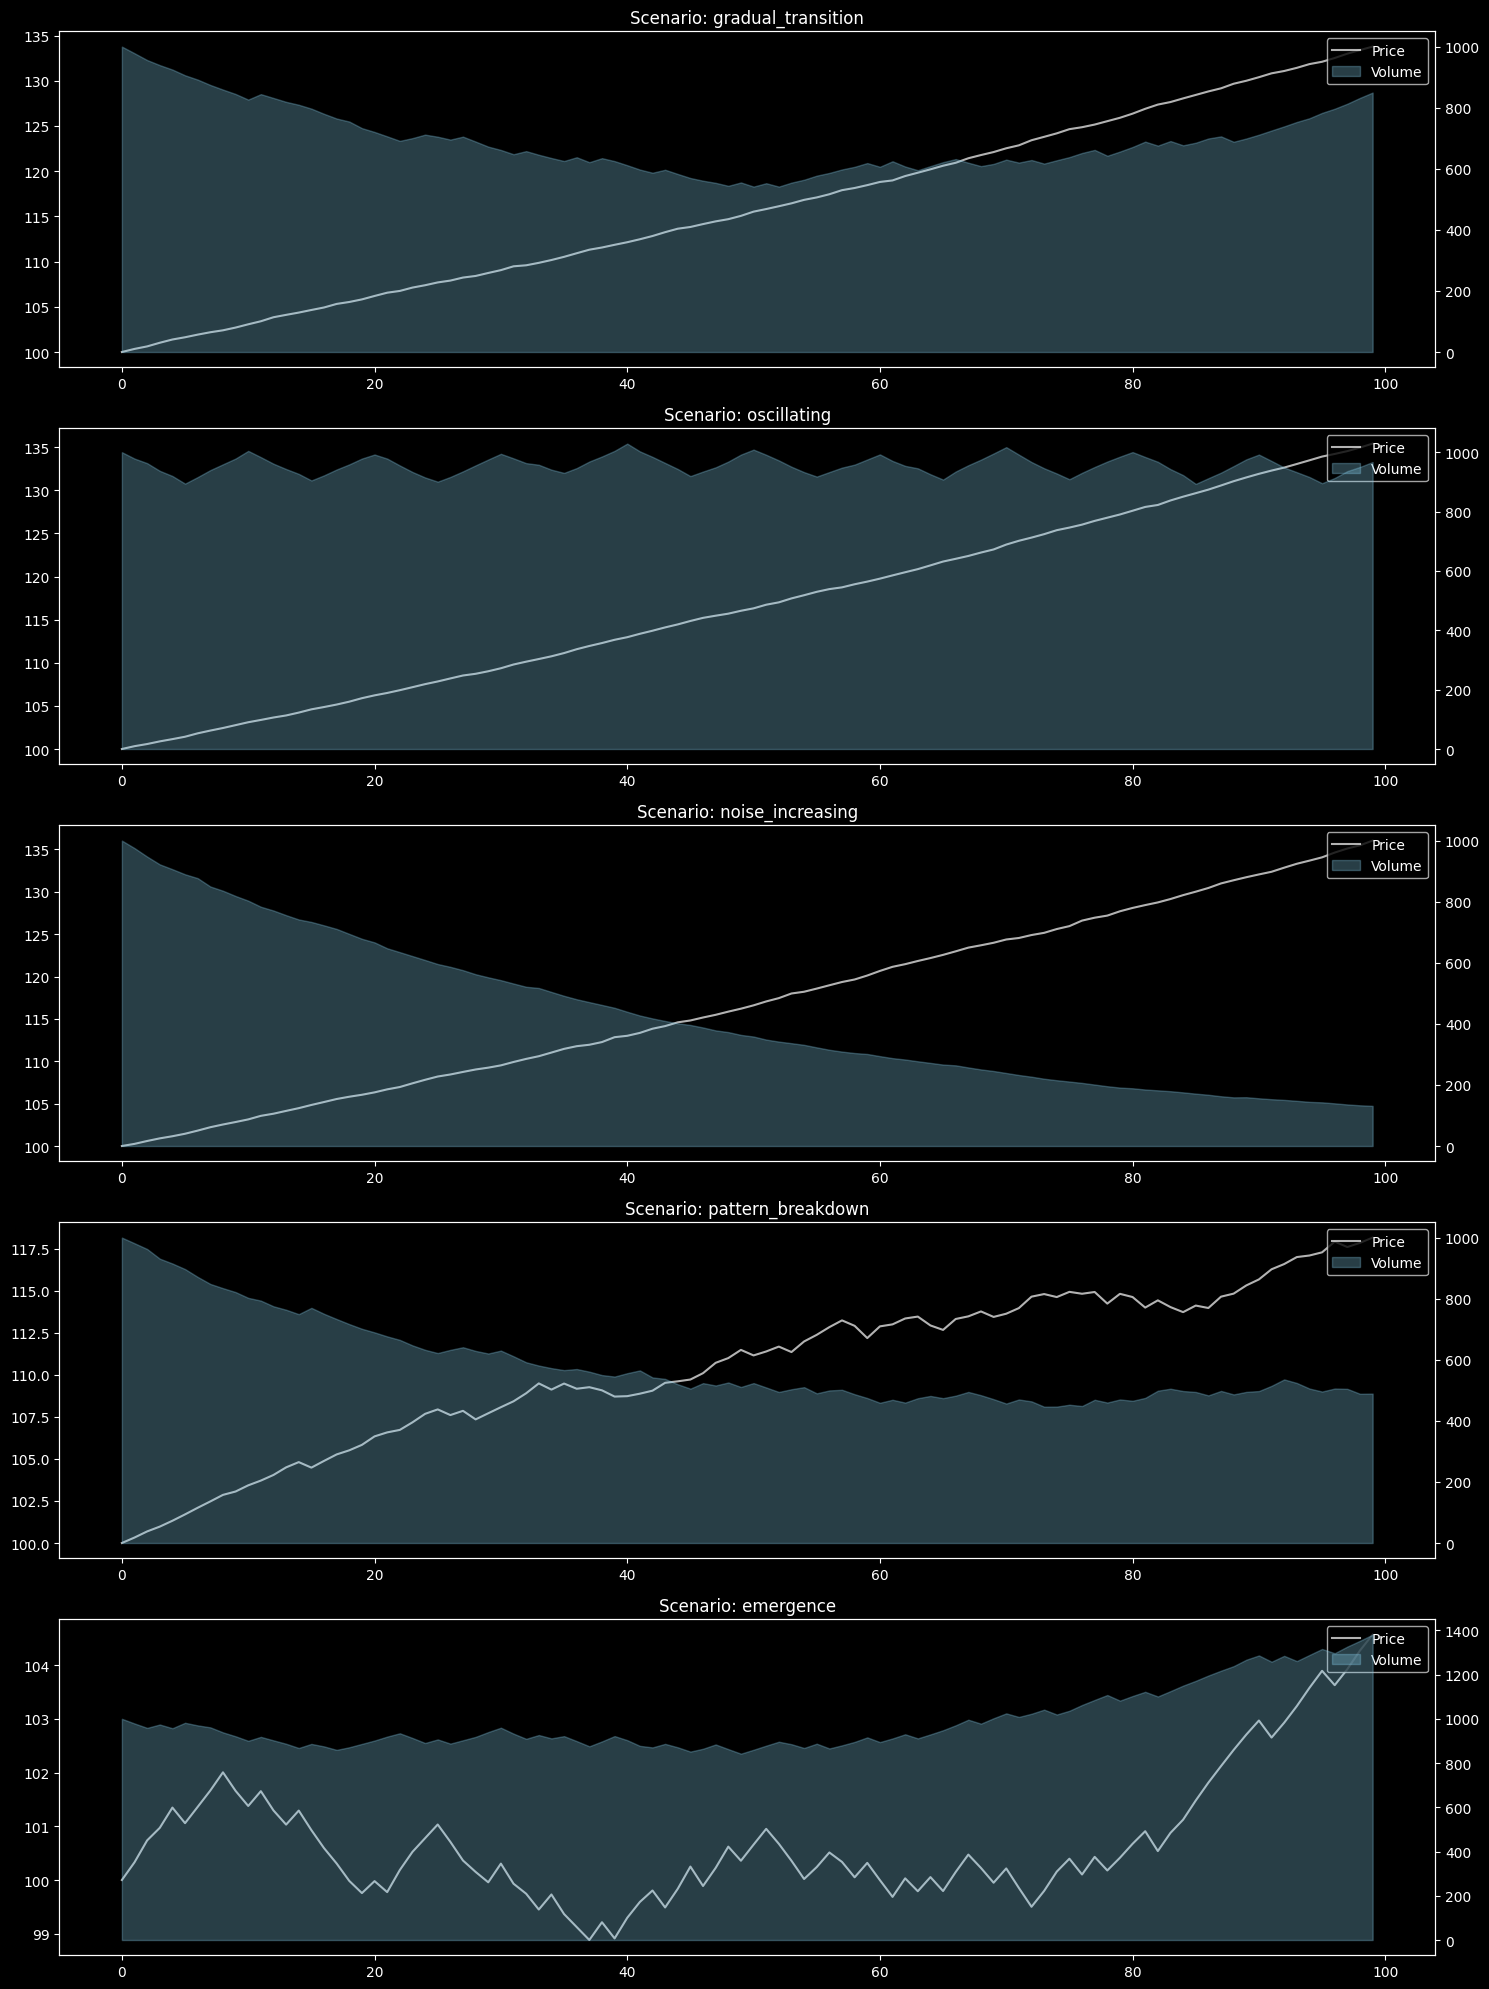

In [16]:
# Test each scenario
scenarios = [
    'gradual_transition',
    'oscillating',
    'noise_increasing',
    'pattern_breakdown',
    'emergence'
]

# Create figure with subplots for each scenario
fig, axes = plt.subplots(len(scenarios), 1, figsize=(15, 4*len(scenarios)))
plt.style.use('dark_background')

for i, scenario in enumerate(scenarios):
    prices, volumes = generate_mixed_pattern_data(scenario, length=100)
    
    # Plot price and volume
    ax1 = axes[i]
    ax1.plot(prices, color='white', label='Price', alpha=0.7)
    ax1.set_title(f'Scenario: {scenario}')
    ax1_twin = ax1.twinx()
    ax1_twin.fill_between(range(len(volumes)), volumes, alpha=0.3, color='skyblue', label='Volume')
    
    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

In [21]:

# Define scenarios and their appropriate parameters
scenarios = {
    'gradual_transition': {
        'target_length': 4,  # Quick response to transition
        'min_pattern_weight': 0.6,  # Moderate threshold for mixed patterns
        'window_size': 15,  # Smaller window to be more responsive
        'noise_level': 0.2
    },
    'oscillating': {
        'target_length': 3,  # Very quick response for oscillations
        'min_pattern_weight': 0.5,  # Lower threshold for rapid switches
        'window_size': 10,  # Small window for quick switches
        'noise_level': 0.15
    },
    'noise_increasing': {
        'target_length': 5,  # Longer for noise stability
        'min_pattern_weight': 0.7,  # Higher threshold for noise filtering
        'window_size': 20,  # Larger window for stability
        'noise_level': 0.1  # Start with low noise
    },
    'pattern_breakdown': {
        'target_length': 4,
        'min_pattern_weight': 0.6,
        'window_size': 15,
        'noise_level': 0.2
    },
    'emergence': {
        'target_length': 4,
        'min_pattern_weight': 0.55,  # Lower threshold to detect emergence
        'window_size': 15,
        'noise_level': 0.2
    }
}
scenario_names = list(scenarios.keys())

In [ ]:
scenario_name = scenario_names[0]
params = scenarios[scenario_name]
print(f"\nAnalyzing {scenario_name} scenario...")

# Generate test data
prices, volumes = generate_mixed_pattern_data(
    scenario=scenario_name,
    length=100,
    noise_level=params['noise_level']
)

# Create date range
dates = pd.date_range(start=datetime.now(), periods=len(prices), freq='D')

# Create data frame
df = pd.DataFrame({
    'date': dates,
    'price': prices,
    'volume': volumes
})

# Initialize pattern detector
detector = PatternRecognition(prices, volumes)

# Detect patterns with scenario-specific parameters
results = detector.detect_volume_price_patterns(
    min_price_change=0.002,
    min_volume_change=0.01,
    window_size=params['window_size'],
    target_length=params['target_length'],
    min_pattern_weight=params['min_pattern_weight']
)

# Create visualization
plt.style.use('dark_background')
fig = plot_pattern_analysis(
    df, 
    results,
    target_length=params['target_length'],
    min_pattern_weight=params['min_pattern_weight'],
    title=f"Pattern Analysis: {scenario_name.replace('_', ' ').title()}\n"
            f"(window={params['window_size']}, target={params['target_length']}, "
            f"threshold={params['min_pattern_weight']:.2f})"
)

# Add parameter annotations
print(f"Scenario Parameters:\n")
print(f"Window Size: {params['window_size']}\n")
print(f"Target Length: {params['target_length']}\n")
print(f"Min Weight: {params['min_pattern_weight']:.2f}\n")
print(f"Initial Noise: {params['noise_level']:.2f}")

# Print pattern statistics
print(f"\nPattern Statistics for {scenario_name}:")
pattern_counts = results['pattern'].value_counts()
print("\nConfirmed Patterns:")
print(pattern_counts)

print("\nPattern Weights Summary:")
weight_stats = results[[col for col in results.columns 
                        if col in VolumePatternType.__members__]].describe()
print(weight_stats)



Analyzing gradual_transition scenario...


Scenario Parameters:

Window Size: 15

Target Length: 4

Min Weight: 0.60

Initial Noise: 0.20

Pattern Statistics for gradual_transition:

Confirmed Patterns:
pattern
DIVERGENCE    50
CONCORDANT    20
NEUTRAL        1
Name: count, dtype: int64

Pattern Weights Summary:
       DIVERGENCE  NON_CONFIRMATION  VOLUME_FORCE     NEUTRAL  CONCORDANT
count  100.000000             100.0    100.000000  100.000000  100.000000
mean     0.559924               0.0      0.046774    0.025142    0.368160
std      0.235890               0.0      0.063808    0.114824    0.250363
min      0.000000               0.0      0.000000    0.000000    0.000000
25%      0.393059               0.0      0.000000    0.000000    0.180809
50%      0.601566               0.0      0.021485    0.000000    0.318304
75%      0.738133               0.0      0.072266    0.000000    0.554522
max      0.969616               0.0      0.316411    1.000000    0.914872


In [24]:
scenario_name = scenario_names[1]
params = scenarios[scenario_name]
print(f"\nAnalyzing {scenario_name} scenario...")

# Generate test data
prices, volumes = generate_mixed_pattern_data(
    scenario=scenario_name,
    length=100,
    noise_level=params['noise_level']
)

# Create date range
dates = pd.date_range(start=datetime.now(), periods=len(prices), freq='D')

# Create data frame
df = pd.DataFrame({
    'date': dates,
    'price': prices,
    'volume': volumes
})

# Initialize pattern detector
detector = PatternRecognition(prices, volumes)

# Detect patterns with scenario-specific parameters
results = detector.detect_volume_price_patterns(
    min_price_change=0.002,
    min_volume_change=0.01,
    window_size=params['window_size'],
    target_length=params['target_length'],
    min_pattern_weight=params['min_pattern_weight']
)

# Create visualization
plt.style.use('dark_background')
fig = plot_pattern_analysis(
    df, 
    results,
    target_length=params['target_length'],
    min_pattern_weight=params['min_pattern_weight'],
    title=f"Pattern Analysis: {scenario_name.replace('_', ' ').title()}\n"
            f"(window={params['window_size']}, target={params['target_length']}, "
            f"threshold={params['min_pattern_weight']:.2f})"
)

# Add parameter annotations
print(f"Scenario Parameters:\n")
print(f"Window Size: {params['window_size']}\n")
print(f"Target Length: {params['target_length']}\n")
print(f"Min Weight: {params['min_pattern_weight']:.2f}\n")
print(f"Initial Noise: {params['noise_level']:.2f}")

# Print pattern statistics
print(f"\nPattern Statistics for {scenario_name}:")
pattern_counts = results['pattern'].value_counts()
print("\nConfirmed Patterns:")
print(pattern_counts)

print("\nPattern Weights Summary:")
weight_stats = results[[col for col in results.columns 
                        if col in VolumePatternType.__members__]].describe()
print(weight_stats)



Analyzing oscillating scenario...


Scenario Parameters:

Window Size: 10

Target Length: 3

Min Weight: 0.50

Initial Noise: 0.15

Pattern Statistics for oscillating:

Confirmed Patterns:
pattern
DIVERGENCE    52
CONCORDANT    47
NEUTRAL        1
Name: count, dtype: int64

Pattern Weights Summary:
       DIVERGENCE  NON_CONFIRMATION  VOLUME_FORCE     NEUTRAL  CONCORDANT
count  100.000000             100.0         100.0  100.000000  100.000000
mean     0.508041               0.0           0.0    0.022583    0.469376
std      0.179756               0.0           0.0    0.113356    0.198229
min      0.000000               0.0           0.0    0.000000    0.000000
25%      0.380234               0.0           0.0    0.000000    0.360623
50%      0.520935               0.0           0.0    0.000000    0.479065
75%      0.619766               0.0           0.0    0.000000    0.619766
max      0.913360               0.0           0.0    1.000000    0.760468


In [25]:
scenario_name = scenario_names[2]
params = scenarios[scenario_name]
print(f"\nAnalyzing {scenario_name} scenario...")

# Generate test data
prices, volumes = generate_mixed_pattern_data(
    scenario=scenario_name,
    length=100,
    noise_level=params['noise_level']
)

# Create date range
dates = pd.date_range(start=datetime.now(), periods=len(prices), freq='D')

# Create data frame
df = pd.DataFrame({
    'date': dates,
    'price': prices,
    'volume': volumes
})

# Initialize pattern detector
detector = PatternRecognition(prices, volumes)

# Detect patterns with scenario-specific parameters
results = detector.detect_volume_price_patterns(
    min_price_change=0.002,
    min_volume_change=0.01,
    window_size=params['window_size'],
    target_length=params['target_length'],
    min_pattern_weight=params['min_pattern_weight']
)

# Create visualization
plt.style.use('dark_background')
fig = plot_pattern_analysis(
    df, 
    results,
    target_length=params['target_length'],
    min_pattern_weight=params['min_pattern_weight'],
    title=f"Pattern Analysis: {scenario_name.replace('_', ' ').title()}\n"
            f"(window={params['window_size']}, target={params['target_length']}, "
            f"threshold={params['min_pattern_weight']:.2f})"
)

# Add parameter annotations
print(f"Scenario Parameters:\n")
print(f"Window Size: {params['window_size']}\n")
print(f"Target Length: {params['target_length']}\n")
print(f"Min Weight: {params['min_pattern_weight']:.2f}\n")
print(f"Initial Noise: {params['noise_level']:.2f}")

# Print pattern statistics
print(f"\nPattern Statistics for {scenario_name}:")
pattern_counts = results['pattern'].value_counts()
print("\nConfirmed Patterns:")
print(pattern_counts)

print("\nPattern Weights Summary:")
weight_stats = results[[col for col in results.columns 
                        if col in VolumePatternType.__members__]].describe()
print(weight_stats)



Analyzing noise_increasing scenario...


Scenario Parameters:

Window Size: 20

Target Length: 5

Min Weight: 0.70

Initial Noise: 0.10

Pattern Statistics for noise_increasing:

Confirmed Patterns:
pattern
DIVERGENCE    98
NEUTRAL        1
Name: count, dtype: int64

Pattern Weights Summary:
       DIVERGENCE  NON_CONFIRMATION  VOLUME_FORCE     NEUTRAL  CONCORDANT
count  100.000000             100.0    100.000000  100.000000       100.0
mean     0.950406               0.0      0.022481    0.027112         0.0
std      0.120618               0.0      0.048725    0.115784         0.0
min      0.000000               0.0      0.000000    0.000000         0.0
25%      0.949745               0.0      0.000000    0.000000         0.0
50%      1.000000               0.0      0.000000    0.000000         0.0
75%      1.000000               0.0      0.013567    0.000000         0.0
max      1.000000               0.0      0.229178    1.000000         0.0



Analyzing pattern_breakdown scenario...


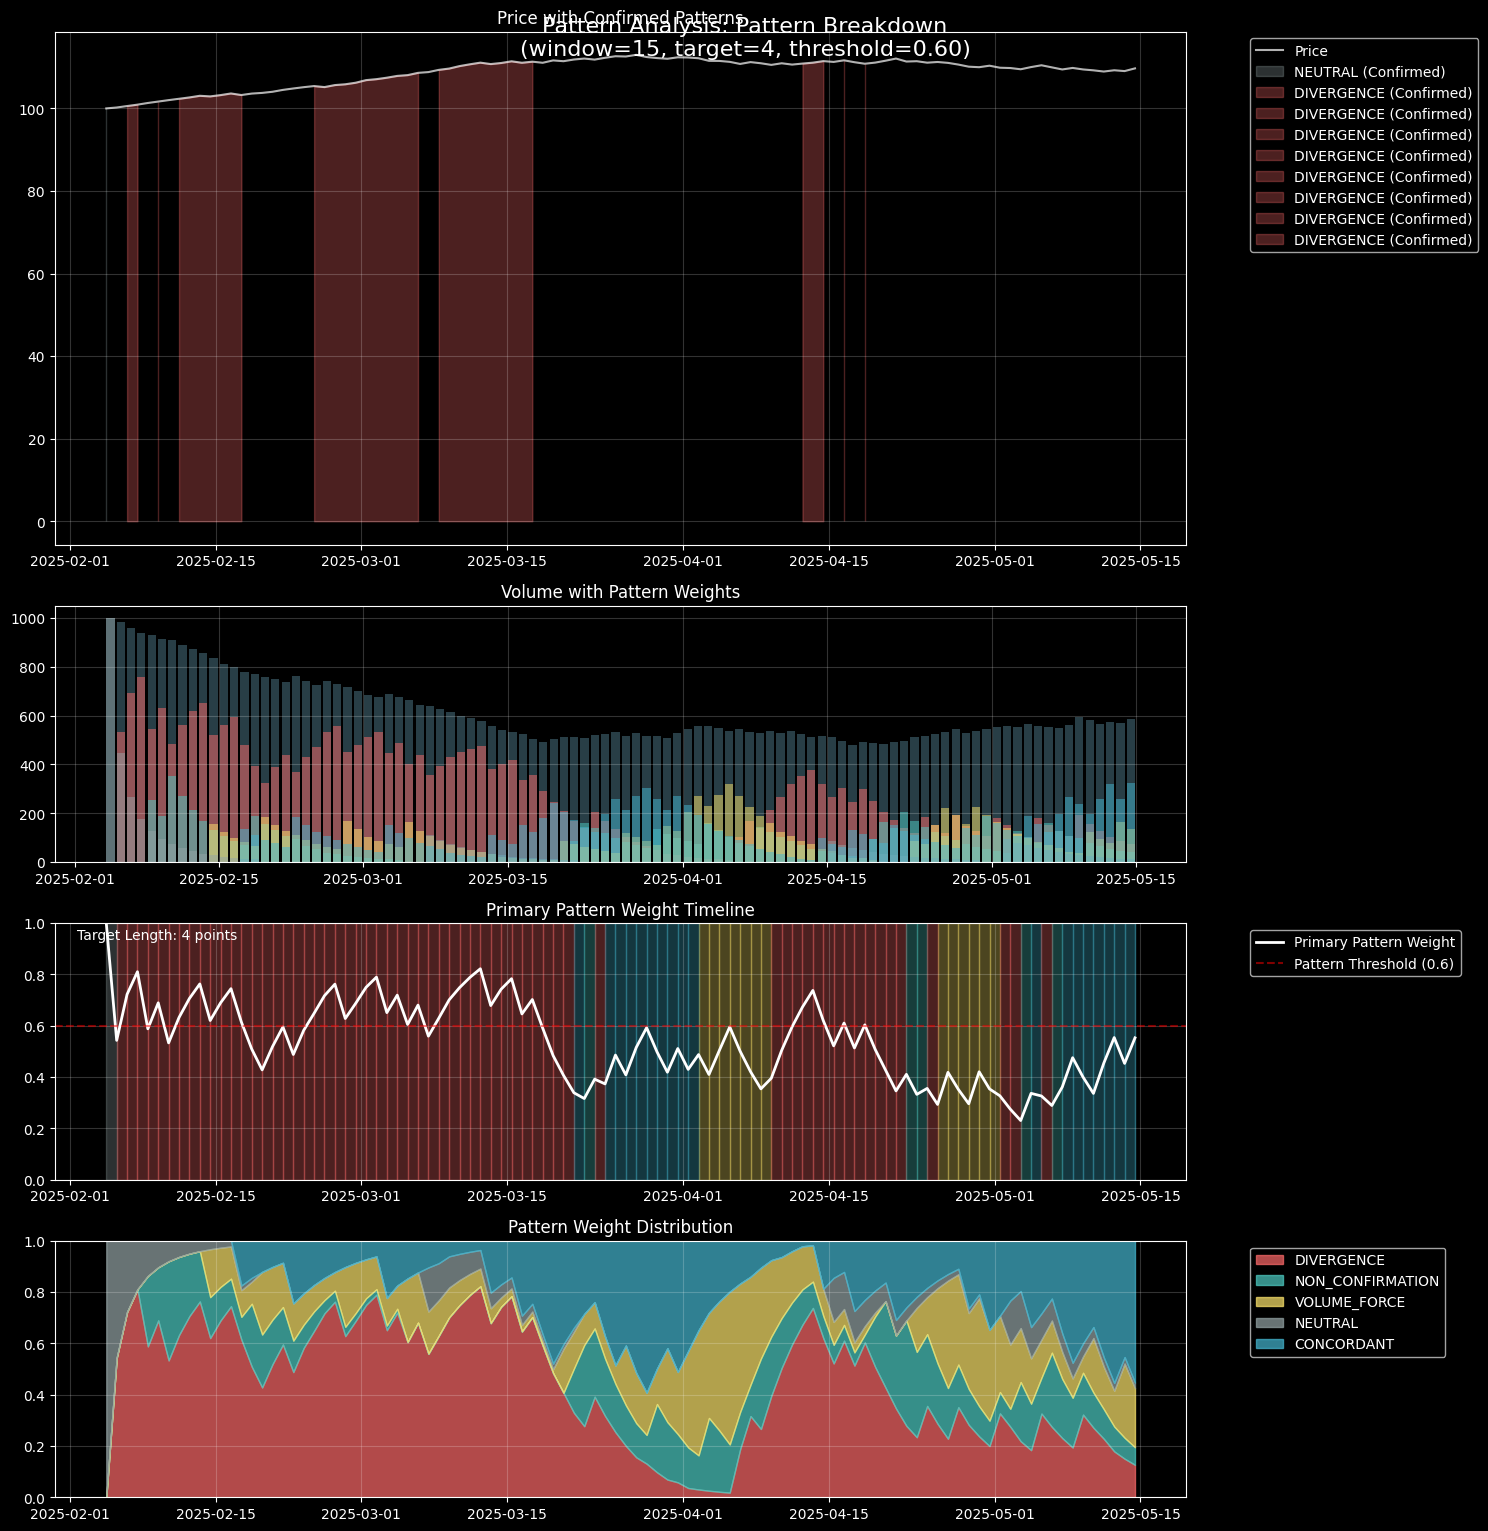

Scenario Parameters:

Window Size: 15

Target Length: 4

Min Weight: 0.60

Initial Noise: 0.20

Pattern Statistics for pattern_breakdown:

Confirmed Patterns:
pattern
DIVERGENCE    36
NEUTRAL        1
Name: count, dtype: int64

Pattern Weights Summary:
       DIVERGENCE  NON_CONFIRMATION  VOLUME_FORCE     NEUTRAL  CONCORDANT
count  100.000000        100.000000    100.000000  100.000000  100.000000
mean     0.447091          0.131967      0.159716    0.054809    0.206417
std      0.236188          0.104855      0.132938    0.117569    0.157195
min      0.000000          0.000000      0.000000    0.000000    0.000000
25%      0.249629          0.030384      0.067785    0.000000    0.086223
50%      0.496310          0.131742      0.138968    0.021485    0.179300
75%      0.649391          0.199909      0.231015    0.065368    0.296460
max      0.822435          0.410807      0.595702    1.000000    0.592551


In [26]:
scenario_name = scenario_names[3]
params = scenarios[scenario_name]
print(f"\nAnalyzing {scenario_name} scenario...")

# Generate test data
prices, volumes = generate_mixed_pattern_data(
    scenario=scenario_name,
    length=100,
    noise_level=params['noise_level']
)

# Create date range
dates = pd.date_range(start=datetime.now(), periods=len(prices), freq='D')

# Create data frame
df = pd.DataFrame({
    'date': dates,
    'price': prices,
    'volume': volumes
})

# Initialize pattern detector
detector = PatternRecognition(prices, volumes)

# Detect patterns with scenario-specific parameters
results = detector.detect_volume_price_patterns(
    min_price_change=0.002,
    min_volume_change=0.01,
    window_size=params['window_size'],
    target_length=params['target_length'],
    min_pattern_weight=params['min_pattern_weight']
)

# Create visualization
plt.style.use('dark_background')
fig = plot_pattern_analysis(
    df, 
    results,
    target_length=params['target_length'],
    min_pattern_weight=params['min_pattern_weight'],
    title=f"Pattern Analysis: {scenario_name.replace('_', ' ').title()}\n"
            f"(window={params['window_size']}, target={params['target_length']}, "
            f"threshold={params['min_pattern_weight']:.2f})"
)

# Add parameter annotations
print(f"Scenario Parameters:\n")
print(f"Window Size: {params['window_size']}\n")
print(f"Target Length: {params['target_length']}\n")
print(f"Min Weight: {params['min_pattern_weight']:.2f}\n")
print(f"Initial Noise: {params['noise_level']:.2f}")

# Print pattern statistics
print(f"\nPattern Statistics for {scenario_name}:")
pattern_counts = results['pattern'].value_counts()
print("\nConfirmed Patterns:")
print(pattern_counts)

print("\nPattern Weights Summary:")
weight_stats = results[[col for col in results.columns 
                        if col in VolumePatternType.__members__]].describe()
print(weight_stats)



Analyzing emergence scenario...


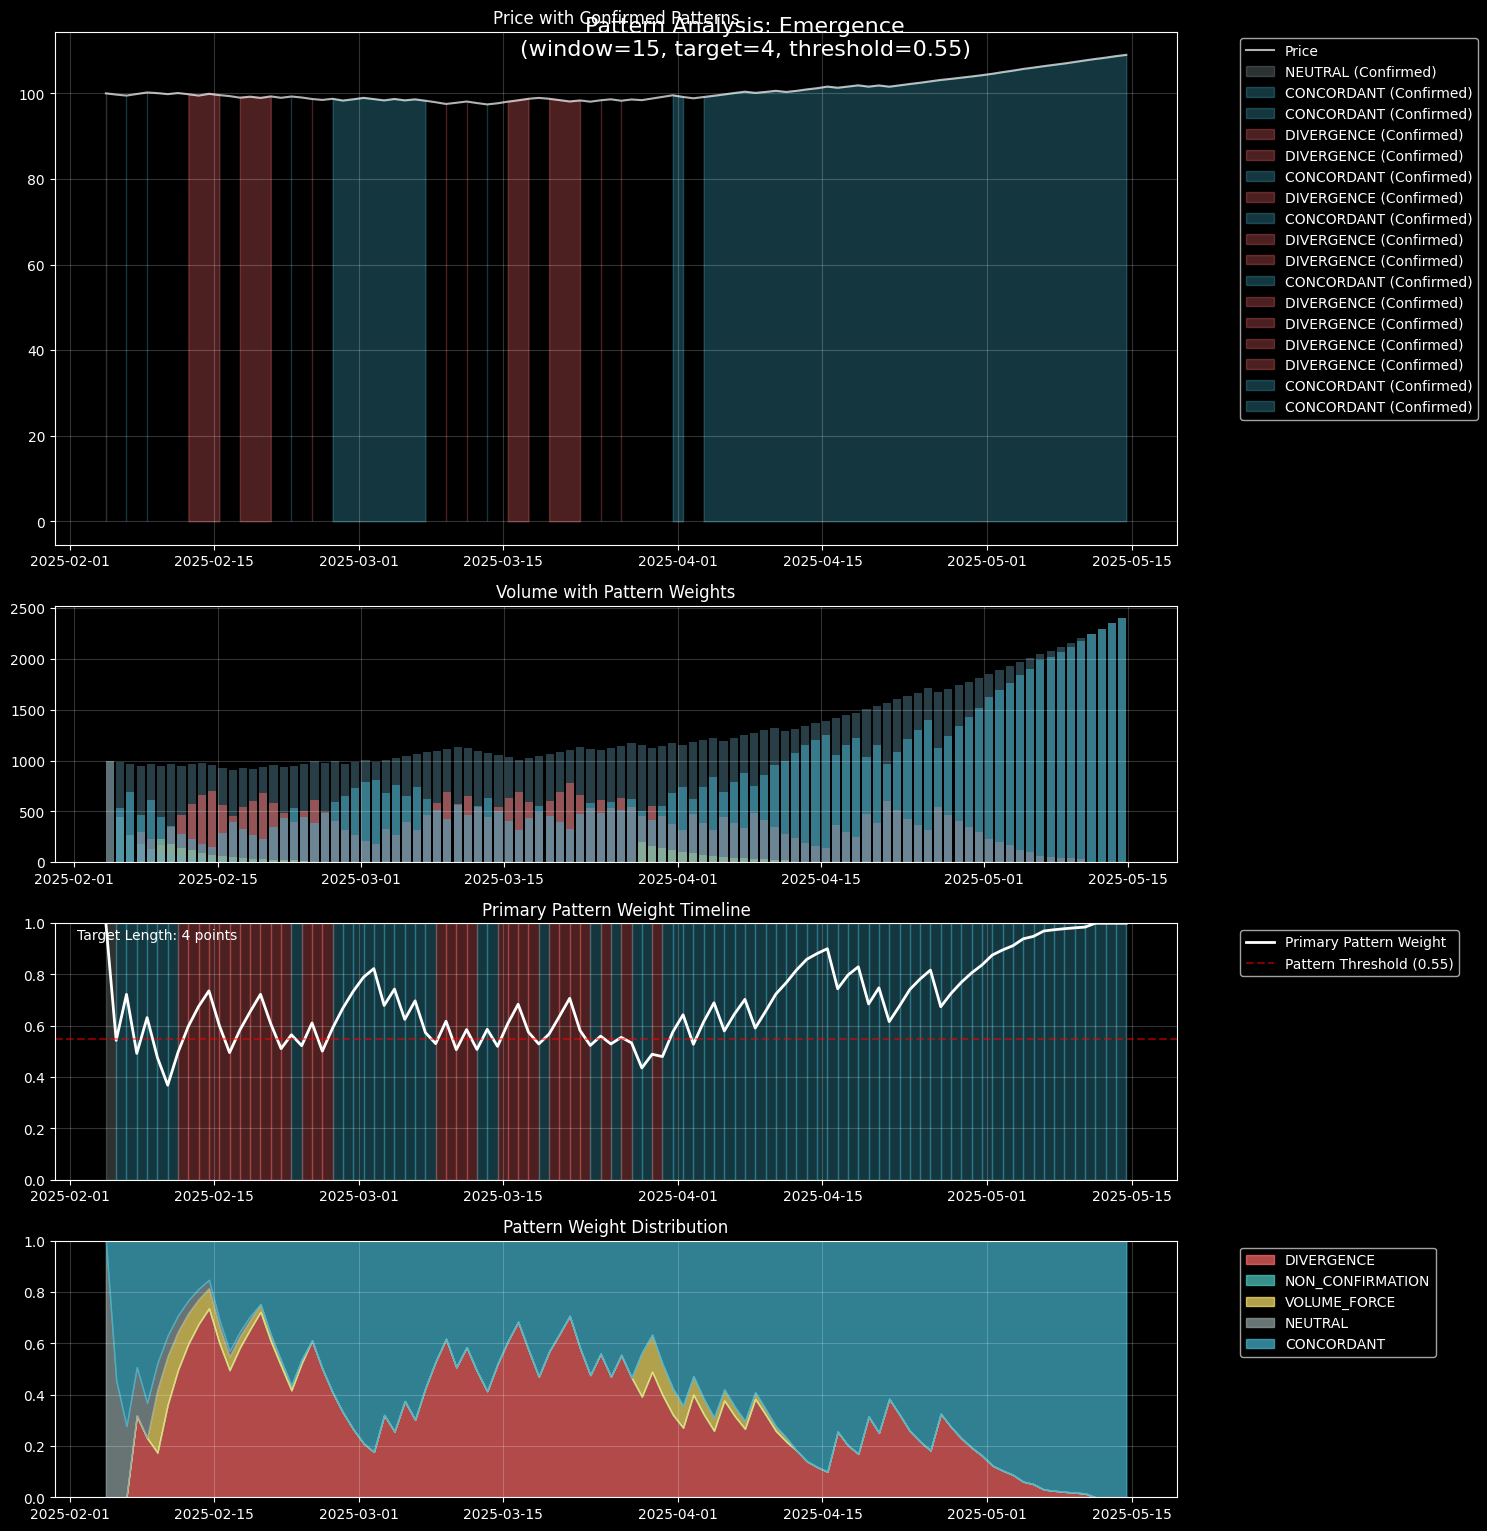

Scenario Parameters:

Window Size: 15

Target Length: 4

Min Weight: 0.55

Initial Noise: 0.20

Pattern Statistics for emergence:

Confirmed Patterns:
pattern
CONCORDANT    58
DIVERGENCE    20
NEUTRAL        1
Name: count, dtype: int64

Pattern Weights Summary:
       DIVERGENCE  NON_CONFIRMATION  VOLUME_FORCE     NEUTRAL  CONCORDANT
count  100.000000             100.0    100.000000  100.000000  100.000000
mean     0.337464               0.0      0.021891    0.025142    0.615503
std      0.205574               0.0      0.046526    0.114824    0.224745
min      0.000000               0.0      0.000000    0.000000    0.000000
25%      0.182784               0.0      0.000000    0.000000    0.443815
50%      0.322507               0.0      0.000000    0.000000    0.616037
75%      0.502606               0.0      0.021485    0.000000    0.784310
max      0.736306               0.0      0.246120    1.000000    1.000000


In [27]:
scenario_name = scenario_names[4]
params = scenarios[scenario_name]
print(f"\nAnalyzing {scenario_name} scenario...")

# Generate test data
prices, volumes = generate_mixed_pattern_data(
    scenario=scenario_name,
    length=100,
    noise_level=params['noise_level']
)

# Create date range
dates = pd.date_range(start=datetime.now(), periods=len(prices), freq='D')

# Create data frame
df = pd.DataFrame({
    'date': dates,
    'price': prices,
    'volume': volumes
})

# Initialize pattern detector
detector = PatternRecognition(prices, volumes)

# Detect patterns with scenario-specific parameters
results = detector.detect_volume_price_patterns(
    min_price_change=0.002,
    min_volume_change=0.01,
    window_size=params['window_size'],
    target_length=params['target_length'],
    min_pattern_weight=params['min_pattern_weight']
)

# Create visualization
plt.style.use('dark_background')
fig = plot_pattern_analysis(
    df, 
    results,
    target_length=params['target_length'],
    min_pattern_weight=params['min_pattern_weight'],
    title=f"Pattern Analysis: {scenario_name.replace('_', ' ').title()}\n"
            f"(window={params['window_size']}, target={params['target_length']}, "
            f"threshold={params['min_pattern_weight']:.2f})"
)

# Add parameter annotations
print(f"Scenario Parameters:\n")
print(f"Window Size: {params['window_size']}\n")
print(f"Target Length: {params['target_length']}\n")
print(f"Min Weight: {params['min_pattern_weight']:.2f}\n")
print(f"Initial Noise: {params['noise_level']:.2f}")

# Print pattern statistics
print(f"\nPattern Statistics for {scenario_name}:")
pattern_counts = results['pattern'].value_counts()
print("\nConfirmed Patterns:")
print(pattern_counts)

print("\nPattern Weights Summary:")
weight_stats = results[[col for col in results.columns 
                        if col in VolumePatternType.__members__]].describe()
print(weight_stats)


In [3]:
dates = pd.date_range(start='2020-01-01', end='2021-12-31', freq='D')
np.random.seed(42)

# Create correlated returns for testing
returns_A = np.random.normal(0, 0.01, len(dates))
# B follows A with lag
returns_B = np.roll(returns_A, 2) + np.random.normal(0, 0.005, len(dates))
# C is independent
returns_C = np.random.normal(0, 0.01, len(dates))

symbols = ["A", "B", "C"]

data = {
    'A': pd.DataFrame({
        'daily_return': pd.Series(returns_A, index=dates)
    }),
    'B': pd.DataFrame({
        'daily_return': pd.Series(returns_B, index=dates)
    }),
    'C': pd.DataFrame({
        'daily_return': pd.Series(returns_C, index=dates)
    })
}

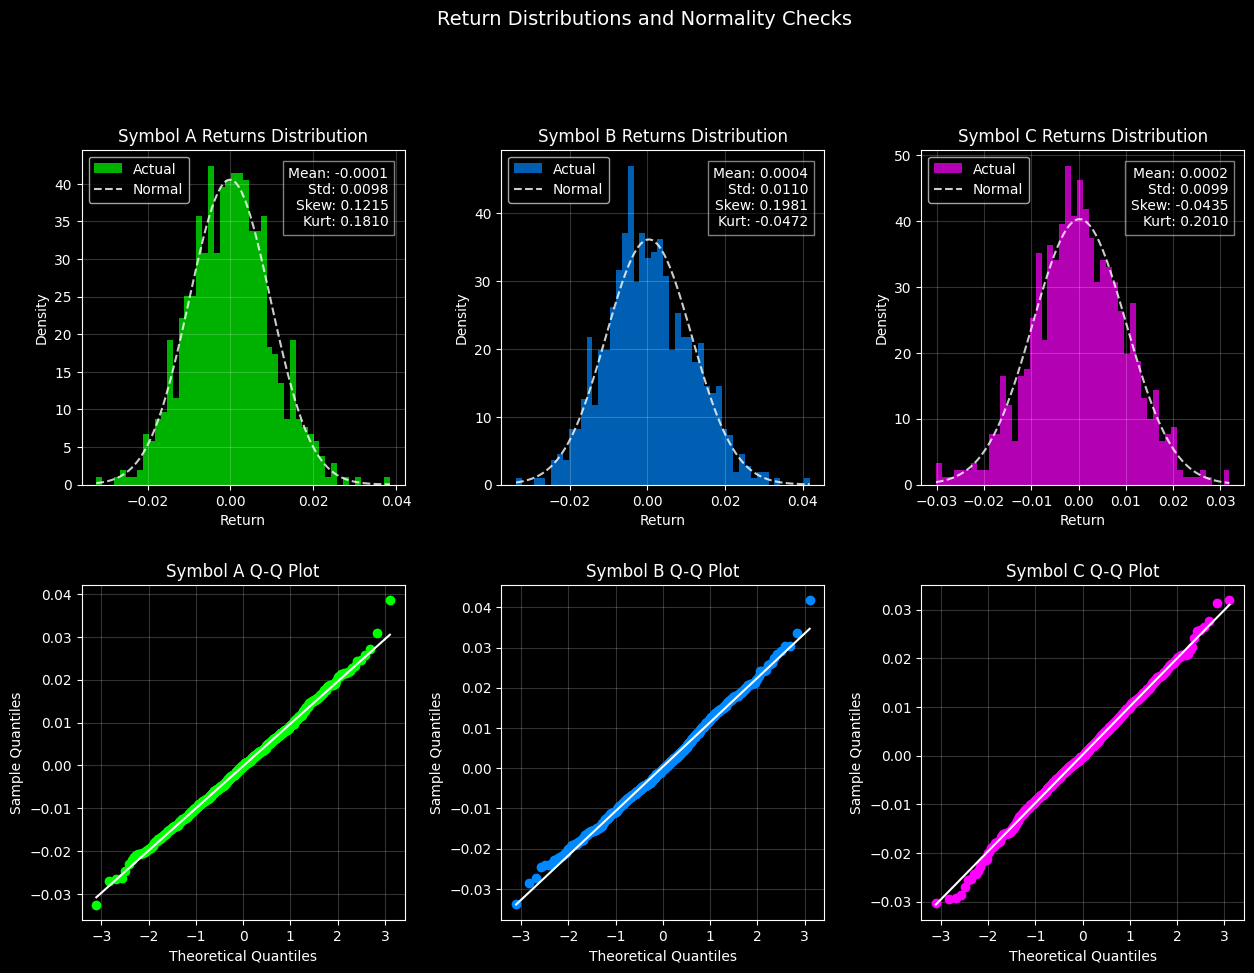

In [22]:
# Create figure with subplots
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Colors for each symbol
colors = {'A': '#00ff00', 'B': '#0088ff', 'C': '#ff00ff'}

# Create histogram subplots
for i, symbol in enumerate(symbols):
    ax = fig.add_subplot(gs[0, i])
    
    returns = data[symbol]['daily_return']
    
    # Plot histogram
    ax.hist(returns, bins=50, alpha=0.7, color=colors[symbol], 
            density=True, label='Actual')
    
    # Add normal distribution curve
    mu = returns.mean()
    sigma = returns.std()
    x = np.linspace(returns.min(), returns.max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 
            'w--', alpha=0.8, label='Normal')
    
    # Add statistics
    stats_text = f'Mean: {mu:.4f}\nStd: {sigma:.4f}\nSkew: {returns.skew():.4f}\nKurt: {returns.kurtosis():.4f}'
    ax.text(0.95, 0.95, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='black', alpha=0.5))
    
    ax.set_title(f'Symbol {symbol} Returns Distribution')
    ax.set_xlabel('Return')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.2)

# Create Q-Q plots
for i, symbol in enumerate(symbols):
    ax = fig.add_subplot(gs[1, i])
    
    returns = data[symbol]['daily_return']
    
    # Create Q-Q plot
    stats.probplot(returns, dist="norm", plot=ax)
    
    # Customize the Q-Q plot for dark theme
    ax.get_lines()[0].set_markerfacecolor(colors[symbol])
    ax.get_lines()[0].set_markeredgecolor(colors[symbol])
    ax.get_lines()[1].set_color('white')
    
    ax.set_title(f'Symbol {symbol} Q-Q Plot')
    ax.grid(True, alpha=0.2)
    
    # Set labels
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')

plt.suptitle('Return Distributions and Normality Checks', y=1.02, size=14)
plt.show()

# Let's also create a box plot to compare the distributions
plt.figure(figsize=(10, 6))
boxplot_data = [data[symbol]['daily_return'] for symbol in symbols]
plt.boxplot(boxplot_data, labels=symbols, patch_artist=True,
            boxprops=dict(facecolor='gray', alpha=0.5),
            medianprops=dict(color='white'),
            flierprops=dict(markerfacecolor='white'))

plt.title('Return Distributions Comparison')
plt.ylabel('Return')
plt.grid(True, alpha=0.2)
plt.show()

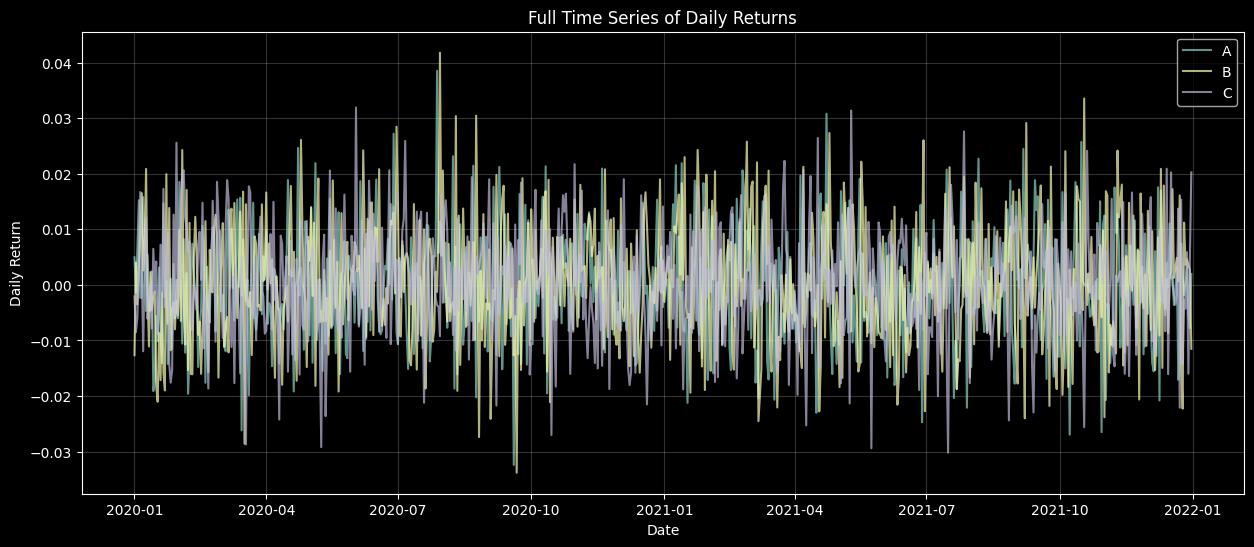

In [19]:
# Create figure
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))
plt.subplots_adjust(hspace=0.3)

# Full time series
for symbol in symbols:
    ax1.plot(dates, data[symbol]['daily_return'], label=symbol, alpha=0.7)

ax1.set_title('Full Time Series of Daily Returns')
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Return')
ax1.legend()
ax1.grid(True, alpha=0.2)

plt.show()

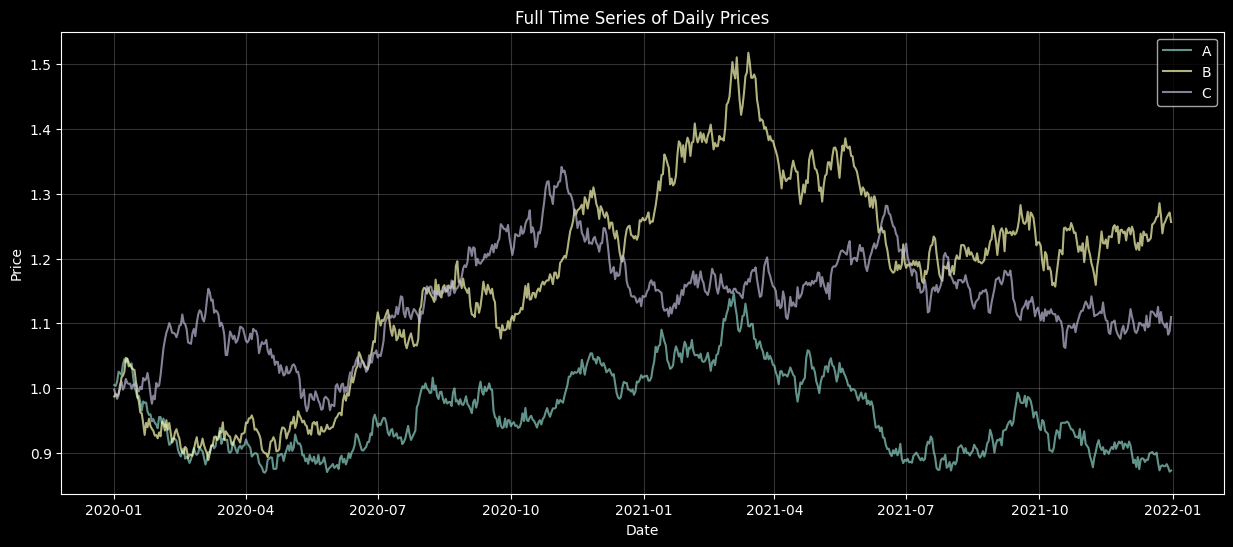

In [20]:
# Create cumulative returns (prices) from returns
prices = {}
for symbol in symbols:
    prices[symbol] = (1 + data[symbol]['daily_return']).cumprod()

# Create figure
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))
plt.subplots_adjust(hspace=0.3)

# price data
for symbol in symbols:
    ax1.plot(dates, prices[symbol], label=symbol, alpha=0.7)

ax1.set_title('Full Time Series of Daily Prices')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.2)

plt.show()    

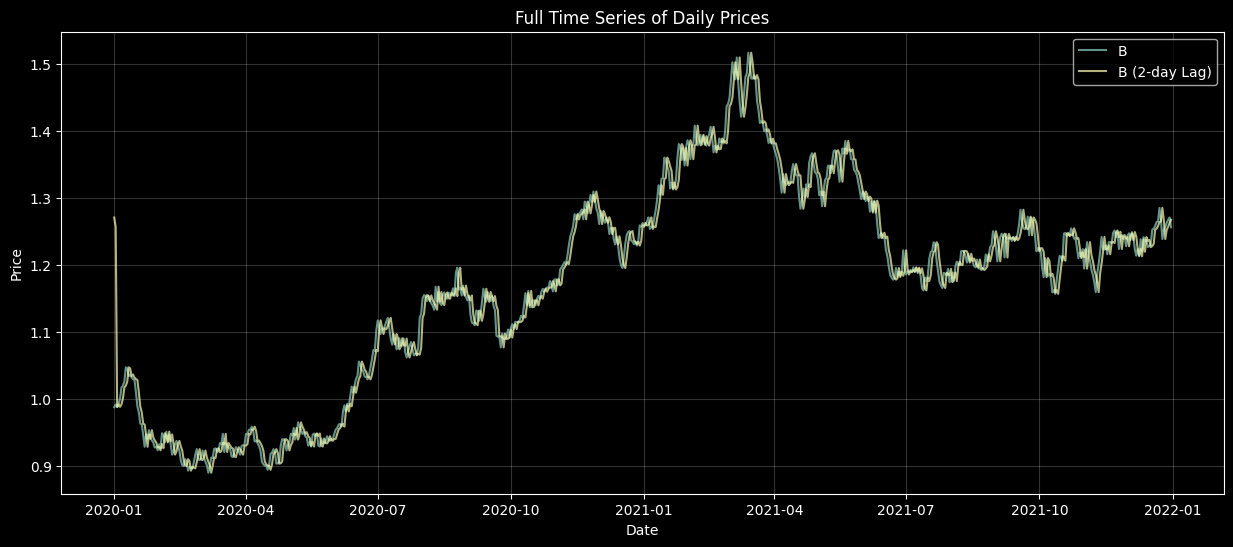

In [23]:
# Create figure
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))
plt.subplots_adjust(hspace=0.3)

ax1.plot(dates, prices["B"], label="B", alpha=0.7)
ax1.plot(dates, np.roll(prices["B"], 2), label = "B (2-day Lag)", alpha = 0.7)

ax1.set_title('Full Time Series of Daily Prices')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.2)

plt.show()    

In [4]:
lead_lag_detector = LeadLagAnalyzer(data)

In [36]:
cross_corrs = lead_lag_detector.calculate_cross_correlations(symbols, max_lags=3)
cross_corrs["abs_corr"] = cross_corrs["correlation"].abs()

In [43]:
# Get unique pairs
pairs = sorted(set([f"{row['symbol1']}-{row['symbol2']}" 
                   for _, row in cross_corrs.iterrows()]))

# Create a color map for pairs
colors = plt.cm.tab10(np.linspace(0, 1, len(pairs)))
pair_colors = dict(zip(pairs, colors))

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(15, 6))

# Calculate bar positions
lags = sorted(cross_corrs['lag'].unique())
x = np.arange(len(lags))
width = 0.8 / len(pairs)  # Adjust bar width based on number of pairs

# Plot bars for each pair
for i, pair in enumerate(pairs):
    symbol1, symbol2 = pair.split('-')
    pair_data = cross_corrs[
        ((cross_corrs['symbol1'] == symbol1) & (cross_corrs['symbol2'] == symbol2)) |
        ((cross_corrs['symbol1'] == symbol2) & (cross_corrs['symbol2'] == symbol1))
    ]
    
    # Sort by lag to ensure alignment
    pair_data = pair_data.sort_values('lag')
    
    ax.bar(x + i*width - width*len(pairs)/2,
           pair_data['correlation'],
           width,
           label=pair,
           color=pair_colors[pair],
           alpha=0.7)

ax.set_title('Grouped Cross-Correlations by Lag')
ax.set_xlabel('Lag')
ax.set_ylabel('Correlation')
ax.set_xticks(x)
ax.set_xticklabels(lags)
ax.grid(True, alpha=0.2)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.show()

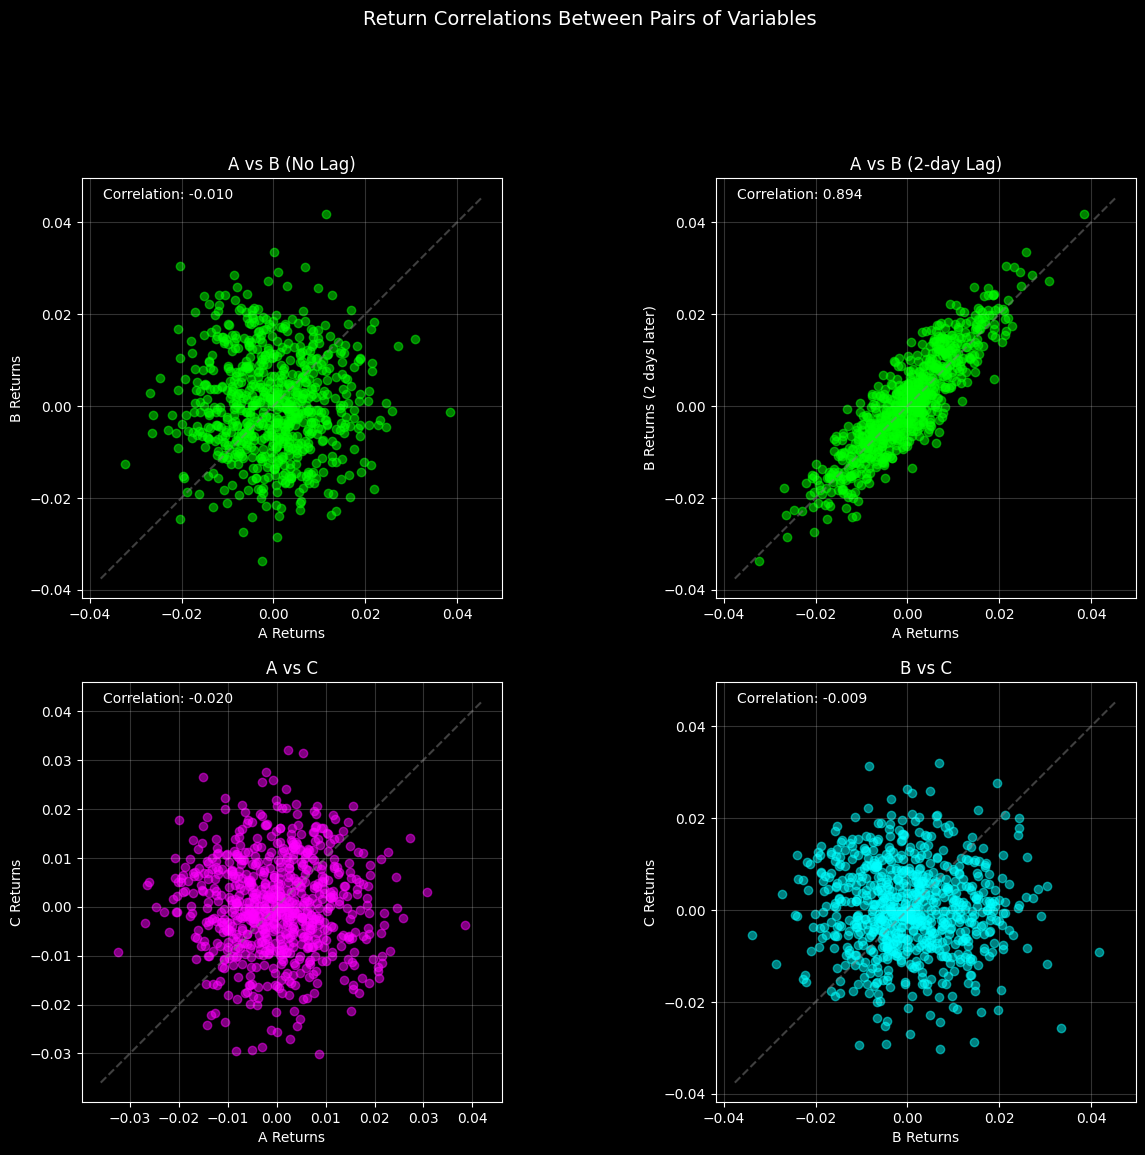

In [47]:
# Create figure with subplots for different correlation views
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. A vs B (no lag)
ax1.scatter(data['A']['daily_return'], data['B']['daily_return'], 
           alpha=0.5, color='#00ff00')
ax1.set_title('A vs B (No Lag)')
ax1.set_xlabel('A Returns')
ax1.set_ylabel('B Returns')
ax1.grid(True, alpha=0.2)

# Calculate and display correlation
corr_no_lag = cross_corrs[(cross_corrs["symbol1"] == "A") & (cross_corrs["symbol2"] == "B") & (cross_corrs["lag"] == 0)]["correlation"].iloc[0]
ax1.text(0.05, 0.95, f'Correlation: {corr_no_lag:.3f}', 
         transform=ax1.transAxes, color='white')

# 2. A vs B (with 2-day lag)
ax2.scatter(data['A']['daily_return'][:-2], data['B']['daily_return'][2:], 
           alpha=0.5, color='#00ff00')
ax2.set_title('A vs B (2-day Lag)')
ax2.set_xlabel('A Returns')
ax2.set_ylabel('B Returns (2 days later)')
ax2.grid(True, alpha=0.2)

# Calculate and display correlation with lag
corr_with_lag = cross_corrs[(cross_corrs["symbol1"] == "A") & (cross_corrs["symbol2"] == "B") & (cross_corrs["lag"] == 2)]["correlation"].iloc[0]
ax2.text(0.05, 0.95, f'Correlation: {corr_with_lag:.3f}', 
         transform=ax2.transAxes, color='white')

# 3. A vs C
ax3.scatter(data['A']['daily_return'], data['C']['daily_return'], 
           alpha=0.5, color='#ff00ff')
ax3.set_title('A vs C')
ax3.set_xlabel('A Returns')
ax3.set_ylabel('C Returns')
ax3.grid(True, alpha=0.2)

# Calculate and display correlation
corr_ac = cross_corrs[(cross_corrs["symbol1"] == "A") & (cross_corrs["symbol2"] == "C") & (cross_corrs["lag"] == 0)]["correlation"].iloc[0]
ax3.text(0.05, 0.95, f'Correlation: {corr_ac:.3f}', 
         transform=ax3.transAxes, color='white')

# 4. B vs C
ax4.scatter(data['B']['daily_return'], data['C']['daily_return'], 
           alpha=0.5, color='#00ffff')
ax4.set_title('B vs C')
ax4.set_xlabel('B Returns')
ax4.set_ylabel('C Returns')
ax4.grid(True, alpha=0.2)

# Calculate and display correlation
corr_bc = cross_corrs[(cross_corrs["symbol1"] == "B") & (cross_corrs["symbol2"] == "C") & (cross_corrs["lag"] == 2)]["correlation"].iloc[0]
ax4.text(0.05, 0.95, f'Correlation: {corr_bc:.3f}', 
         transform=ax4.transAxes, color='white')

# Add diagonal lines for reference
for ax in [ax1, ax2, ax3, ax4]:
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, '--', color='gray', alpha=0.5)
    ax.set_aspect('equal')

plt.suptitle('Return Correlations Between Pairs of Variables', y=1.02, size=14)
plt.show()

In [56]:
# Create figure with subplots for different correlation views
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 1. A vs B (with 2-day lag)
ax1.scatter(data['A']['daily_return'][:-2], data['B']['daily_return'][2:], 
           alpha=0.5, color='#00ff00')
ax1.set_title('A vs B (2-day Lag)')
ax1.set_xlabel('A Returns')
ax2.set_ylabel('B Returns (2 days later)')
ax1.grid(True, alpha=0.2)

# Calculate and display correlation
corr_no_lag = cross_corrs[(cross_corrs["symbol1"] == "A") & (cross_corrs["symbol2"] == "B") & (cross_corrs["lag"] == 2)]["correlation"].iloc[0]
ax1.text(0.05, 0.95, f'Correlation: {corr_no_lag:.3f}', 
         transform=ax1.transAxes, color='white')

# 2. A vs C (with 2-day lag)
ax2.scatter(data['A']['daily_return'][:-2], data['C']['daily_return'][2:], 
           alpha=0.5, color='#00ff00')
ax2.set_title('A vs C (2-day Lag)')
ax2.set_xlabel('A Returns')
ax2.set_ylabel('C Returns (2 days later)')
ax2.grid(True, alpha=0.2)

# Calculate and display correlation with lag
corr_with_lag = cross_corrs[(cross_corrs["symbol1"] == "A") & (cross_corrs["symbol2"] == "C") & (cross_corrs["lag"] == 2)]["correlation"].iloc[0]
ax2.text(0.05, 0.95, f'Correlation: {corr_with_lag:.3f}', 
         transform=ax2.transAxes, color='white')

# 3. B vs C
ax3.scatter(data['B']['daily_return'][:-2], data['C']['daily_return'][2:], 
           alpha=0.5, color='#ff00ff')
ax3.set_title('B vs C (2-day Lag)')
ax3.set_xlabel('B Returns')
ax2.set_ylabel('C Returns (2 days later)')
ax3.grid(True, alpha=0.2)

# Calculate and display correlation
corr_ac = cross_corrs[(cross_corrs["symbol1"] == "B") & (cross_corrs["symbol2"] == "C") & (cross_corrs["lag"] == 0)]["correlation"].iloc[0]
ax3.text(0.05, 0.95, f'Correlation: {corr_ac:.3f}', 
         transform=ax3.transAxes, color='white')

# Add diagonal lines for reference
for ax in [ax1, ax2, ax3]:
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, '--', color='gray', alpha=0.5)
    ax.set_aspect('equal')

plt.suptitle('Return Correlations Between Pairs of Variables', y=1.02, size=14)
plt.show()

In [8]:
results = lead_lag_detector.test_granger_causality(["A", "B", "C"], max_lag = 3)

In [9]:
results

cause effect  lag        p_value        r2 significant_coefficients
0      A      B    2  5.982476e-253  0.799378            Lag 2: 1.0013
1      A      B    3  4.434004e-251  0.800270            Lag 2: 1.0021
2      B      A    3   2.260853e-02  0.014255                         
3      B      A    2   5.289647e-02  0.008908           Lag 2: -0.0677
4      B      A    1   1.878567e-01  0.003124                         
5      B      C    1   2.506176e-01  0.001962                         
6      C      A    1   4.541438e-01  0.001512                         
7      B      C    2   5.108303e-01  0.003180                         
8      A      B    1   5.386563e-01  0.002522                         
9      C      B    1   5.506112e-01  0.002492                         
10     B      C    3   5.845907e-01  0.004318                         
11     C      A    2   6.005875e-01  0.002234                         
12     C      B    3   6.174321e-01  0.005998                         
13     C      A    3   7.110437e-01  0.002998                         
14     A      C    3   7.177816e-01  0.003498                         
15     C      B    2   7.205599e-01  0.002912                         
16     A      C    2   7.254892e-01  0.002213                         
17     A      C    1   7.655738e-01  0.000269

In [10]:
def create_synthetic_returns(n_days=1000):
    """
    Create synthetic daily returns with stronger relationships
    """
    dates = pd.date_range(start='2021-01-01', periods=n_days, freq='B')
    
    # Increase the factor impacts and reduce noise
    market_factor = np.random.normal(0.0005, 0.01, n_days)
    tech_factor = np.random.normal(0.0007, 0.02, n_days)    # Increased volatility
    energy_factor = np.random.normal(0.0003, 0.015, n_days) # Increased volatility
    consumer_factor = np.random.normal(0.0004, 0.012, n_days)
    
    # Reduce individual noise and increase factor loadings
    returns_data = {}
    
    # Tech stocks - increased correlations
    returns_data['AAPL'] = pd.Series(0.6*market_factor + 0.9*tech_factor + np.random.normal(0, 0.005, n_days), index=dates)
    returns_data['MSFT'] = pd.Series(0.6*market_factor + 0.85*tech_factor + np.random.normal(0, 0.005, n_days), index=dates)
    returns_data['GOOGL'] = pd.Series(0.6*market_factor + 0.8*tech_factor + np.random.normal(0, 0.005, n_days), index=dates)
    
    # Energy stocks - increased correlations
    returns_data['XOM'] = pd.Series(0.4*market_factor + 0.9*energy_factor + np.random.normal(0, 0.005, n_days), index=dates)
    returns_data['CVX'] = pd.Series(0.4*market_factor + 0.85*energy_factor + np.random.normal(0, 0.005, n_days), index=dates)
    returns_data['BP'] = pd.Series(0.4*market_factor + 0.8*energy_factor + np.random.normal(0, 0.005, n_days), index=dates)
    
    # Consumer stocks - moderately increased correlations
    returns_data['WMT'] = pd.Series(0.3*market_factor + 0.8*consumer_factor + np.random.normal(0, 0.006, n_days), index=dates)
    returns_data['TGT'] = pd.Series(0.3*market_factor + 0.75*consumer_factor + np.random.normal(0, 0.006, n_days), index=dates)
    returns_data['COST'] = pd.Series(0.3*market_factor + 0.7*consumer_factor + np.random.normal(0, 0.006, n_days), index=dates)
    
    # Independent stocks - reduced market correlation
    returns_data['GS'] = pd.Series(0.4*market_factor + np.random.normal(0, 0.015, n_days), index=dates)
    returns_data['PG'] = pd.Series(0.3*market_factor + np.random.normal(0, 0.01, n_days), index=dates)
    
    returns_df = pd.DataFrame(returns_data)
    
    formatted_returns = {
        symbol: {'daily_return': returns_df[symbol]}
        for symbol in returns_df.columns
    }
    
    return formatted_returns

# Main changes made:
# 1. Increased factor volatilities
# 2. Increased factor loadings (0.9, 0.85, 0.8 instead of 0.8, 0.75, 0.7)
# 3. Reduced individual stock noise (0.005 instead of 0.01)
# 4. Reduced market factor impact on non-market stocks

# Now we should see:
# - Tech correlations: ~0.8-0.9
# - Energy correlations: ~0.8-0.9
# - Consumer correlations: ~0.6-0.7
# - Other correlations: <0.4

# Create the synthetic data
returns_data = create_synthetic_returns()

# List of all symbols
symbols = ['AAPL', 'MSFT', 'GOOGL', 'XOM', 'CVX', 'BP', 'WMT', 'TGT', 'COST', 'GS', 'PG']

In [11]:
lead_lag_detector = LeadLagAnalyzer(returns_data)
cross_corrs = lead_lag_detector.calculate_cross_correlations(symbols, max_lags = 1)
cross_corrs = cross_corrs[cross_corrs["lag"] == 0]

In [12]:
G = lead_lag_detector.build_relationship_network(symbols, threshold = 0.6)

In [ ]:
def adjust_positions(pos, min_dist=0.3):
    """
    Adjust node positions to maintain minimum distance and reduce overlaps
    """
    adjusted = True
    while adjusted:
        adjusted = False
        nodes = list(pos.keys())
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                node1, node2 = nodes[i], nodes[j]
                x1, y1 = pos[node1]
                x2, y2 = pos[node2]
                dist = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
                if dist < min_dist:
                    # Push nodes apart
                    angle = math.atan2(y2 - y1, x2 - x1)
                    push = (min_dist - dist) / 2
                    pos[node1] = (x1 - push * math.cos(angle), y1 - push * math.sin(angle))
                    pos[node2] = (x2 + push * math.cos(angle), y2 + push * math.sin(angle))
                    adjusted = True
    return pos

def create_better_layout(G):
    # First identify connected components
    components = list(nx.connected_components(G))
    
    # Get initial layout for each component separately
    pos = {}
    spacing = 2.0  # Space between components
    current_x = 0
    
    for component in components:
        subgraph = G.subgraph(component)
        if len(component) > 1:
            # For connected components, use spring layout
            subpos = nx.spring_layout(subgraph, k=1.0)
            
            # Shift the component to current_x
            max_x = max(p[0] for p in subpos.values())
            min_x = min(p[0] for p in subpos.values())
            shift_x = current_x - min_x
            
            for node in subpos:
                pos[node] = (subpos[node][0] + shift_x, subpos[node][1])
            
            current_x += (max_x - min_x) + spacing
        else:
            # For isolated nodes, place them in a line
            node = list(component)[0]
            pos[node] = (current_x, 0)
            current_x += spacing
    
    # Adjust positions to prevent overlaps
    pos = adjust_positions(pos)
    
    return pos

def plot_network(G):
    # Get improved node positions
    pos = create_better_layout(G)

    # Create edges with improved styling
    edge_x = []
    edge_y = []
    edge_text = []
    edge_labels = []
    edge_label_positions = []

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_text.append(f"{edge[0]} → {edge[1]}<br>Correlation: {edge[2]['weight']:.2f}")
        
        # Calculate middle point for edge label with offset
        mid_x = (x0 + x1) / 2
        mid_y = (y0 + y1) / 2 + 0.1  # Slight vertical offset for edge labels
        edge_label_positions.append((mid_x, mid_y))
        edge_labels.append(f"{edge[2]['weight']:.2f}")

    # Create edge trace
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=2, color='rgba(255, 255, 255, 0.3)'),
        hoverinfo='text',
        text=edge_text,
        mode='lines')

    # Create edge label trace
    edge_label_trace = go.Scatter(
        x=[pos[0] for pos in edge_label_positions],
        y=[pos[1] for pos in edge_label_positions],
        mode='text',
        text=edge_labels,
        textposition="middle center",
        hoverinfo='none',
        textfont=dict(
            size=12,
            color='rgba(255, 255, 255, 0.8)'
        ))

    # Create nodes
    node_x = []
    node_y = []
    node_text = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        num_connections = len(list(G.neighbors(node)))
        node_text.append(f"{node}<br>Connections: {num_connections}")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        text=[node for node in G.nodes()],
        textposition="top center",
        textfont=dict(
            color='white',
            size=14
        ),
        marker=dict(
            size=25,
            line=dict(
                color='white',
                width=1
            )
        ))

    # Color nodes by their role
    node_colors = []
    for node in G.nodes():
        num_connections = len(list(G.neighbors(node)))
        if num_connections == 0:
            node_colors.append('#465C69')  # isolated nodes
        elif num_connections == 1:
            node_colors.append('#4A90E2')  # leaf nodes
        else:
            node_colors.append('#6FCF97')  # hub nodes

    node_trace.marker.color = node_colors

    # Update axis ranges based on positions
    x_coords = [pos[node][0] for node in G.nodes()]
    y_coords = [pos[node][1] for node in G.nodes()]
    x_range = [min(x_coords) - 0.5, max(x_coords) + 0.5]
    y_range = [min(y_coords) - 0.5, max(y_coords) + 0.5]

    # Create the figure
    fig = go.Figure(data=[edge_trace, edge_label_trace, node_trace],
                    layout=go.Layout(
                        title=dict(
                            text='Stock Relationship Network',
                            font=dict(color='white', size=16),
                            x=0.5,
                            y=0.95
                        ),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        plot_bgcolor='rgb(17, 17, 17)',
                        paper_bgcolor='rgb(17, 17, 17)',
                        xaxis=dict(
                            showgrid=False, 
                            zeroline=False, 
                            showticklabels=False,
                            range=x_range
                        ),
                        yaxis=dict(
                            showgrid=False, 
                            zeroline=False, 
                            showticklabels=False,
                            range=y_range,
                            scaleanchor="x",
                            scaleratio=1
                        ),
                        annotations=[
                            dict(
                                x=1.0, y=1.0,
                                xref="paper", yref="paper",
                                text="Hub Node",
                                showarrow=False,
                                font=dict(color='#6FCF97', size=12),
                                bgcolor='rgba(0,0,0,0.5)',
                                bordercolor='white',
                                borderwidth=1,
                                borderpad=4
                            ),
                            dict(
                                x=1.0, y=0.95,
                                xref="paper", yref="paper",
                                text="Connected Node",
                                showarrow=False,
                                font=dict(color='#4A90E2', size=12),
                                bgcolor='rgba(0,0,0,0.5)',
                                bordercolor='white',
                                borderwidth=1,
                                borderpad=4
                            ),
                            dict(
                                x=1.0, y=0.90,
                                xref="paper", yref="paper",
                                text="Isolated Node",
                                showarrow=False,
                                font=dict(color='#465C69', size=12),
                                bgcolor='rgba(0,0,0,0.5)',
                                bordercolor='white',
                                borderwidth=1,
                                borderpad=4
                            )
                        ]
                    ))
    fig.show()
    return

plot_network(G)

In [7]:
lead_lag_detector.find_market_leaders(["A", "B", "C"])

{'A': np.float64(1.0),
 'B': np.float64(0.00017431106351540105),
 'C': np.float64(0.0)}

In [2]:
dates = pd.date_range(start='2020-01-01', end='2021-12-31', freq='D')
n_points = len(dates)
np.random.seed(42)

# Calculate segment sizes to ensure we use all points
segment_size = n_points // 3
remainder = n_points % 3
segment_sizes = [segment_size] * 3
# Distribute remainder across segments
for i in range(remainder):
    segment_sizes[i] += 1
    
# Create returns with regime shifts
returns = []
volumes = []

# Normal regime
returns.extend(np.random.normal(0.001, 0.01, segment_sizes[0]))
volumes.extend(np.random.normal(1000000, 100000, segment_sizes[0]))

# High volatility regime
returns.extend(np.random.normal(-0.002, 0.03, segment_sizes[1]))
volumes.extend(np.random.normal(2000000, 300000, segment_sizes[1]))

# Low volatility regime
returns.extend(np.random.normal(0.0005, 0.005, segment_sizes[2]))
volumes.extend(np.random.normal(800000, 50000, segment_sizes[2]))

returns = np.array(returns)
volumes = np.array(volumes)
prices = 100 * (1 + returns).cumprod()

data = {
    'TEST': pd.DataFrame({
        'daily_return': pd.Series(returns, index=dates),
        'close': pd.Series(prices, index=dates),
        'volume': pd.Series(volumes, index=dates)
    })
}

In [117]:
returns = data["TEST"]['daily_return']
prices = data["TEST"]['close']
volumes = data["TEST"]['volume']

regime_detector = RegimeAnalyzer(returns, prices, volumes)

In [118]:
def create_dark_mode_plots(data, symbol='TEST'):
    """Create dark-themed visualization of financial data"""
    
    df = data[symbol]
    
    # Create figure with secondary y-axis
    fig = go.Figure()
    
    # Create subplots
    fig = make_subplots(rows=3, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.05,
                        subplot_titles=('Price', 'Returns', 'Volume'),
                        row_heights=[0.5, 0.25, 0.25])

    # Add price data
    fig.add_trace(
        go.Scatter(x=df.index, y=df['close'],
                  name='Price',
                  line=dict(color='#00D3FF', width=1)),
        row=1, col=1
    )

    # Add returns data
    fig.add_trace(
        go.Scatter(x=df.index, y=df['daily_return'],
                  name='Returns',
                  line=dict(color='#FF9900', width=1)),
        row=2, col=1
    )

    # Add volume data
    fig.add_trace(
        go.Bar(x=df.index, y=df['volume'],
               name='Volume',
               marker_color='#00FF88'),
        row=3, col=1
    )

    # Update layout for dark theme
    fig.update_layout(
        template='plotly_dark',
        paper_bgcolor='rgb(30,30,30)',
        plot_bgcolor='rgb(30,30,30)',
        title={
            'text': f'{symbol} Price, Returns, and Volume Analysis',
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20, color='white')
        },
        showlegend=True,
        legend=dict(
            bgcolor='rgba(0,0,0,0)',
            font=dict(color='white')
        ),
        height=900,
        margin=dict(t=100)
    )

    # Update axes
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.2)',
                     zeroline=False, showline=True, linewidth=1, linecolor='gray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.2)',
                     zeroline=False, showline=True, linewidth=1, linecolor='gray')

    # Add hover effects
    fig.update_traces(hovertemplate='Date: %{x}<br>Value: %{y:.6f}<extra></extra>')

    return fig

# Create and show the plot
fig = create_dark_mode_plots(data)
fig.show()

In [119]:
regimes = regime_detector.detect_hmm_regimes(n_states = 3)

Model is not converging.  Current: 2570.3028749650002 is not greater than 2570.445888901183. Delta is -0.1430139361827969


In [121]:
regimes["regime"].value_counts()

#Ok I should allow the user to select which features to use for regime detection....I'll have to think about how I want to do that.

regime
0    485
2    245
1      1
Name: count, dtype: int64

In [122]:
structural_breaks = regime_detector.detect_structural_breaks()

In [124]:
structural_breaks["significant_break"].value_counts()

significant_break
False    494
True     237
Name: count, dtype: int64

In [133]:
def create_dark_mode_plots_with_breaks(data, structural_breaks, symbol='TEST'):
    """Create dark-themed visualization of financial data with breaks shown on relevant charts"""
    
    df = data[symbol]
    
    # Create figure with subplots
    fig = make_subplots(rows=3, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.05,
                        subplot_titles=('Price', 'Returns (with Volatility Breaks)', 'Volume (with Volume Breaks)'),
                        row_heights=[0.5, 0.25, 0.25])

    # Add main traces
    fig.add_trace(
        go.Scatter(x=df.index, y=df['close'],
                  name='Price',
                  line=dict(color='#00D3FF', width=1)),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=df.index, y=df['daily_return'],
                  name='Returns',
                  line=dict(color='#FF9900', width=1)),
        row=2, col=1
    )

    fig.add_trace(
        go.Bar(x=df.index, y=df['volume'],
               name='Volume',
               marker_color='#00FF88'),
        row=3, col=1
    )

    # Get break dates for each type
    vol_breaks = structural_breaks[structural_breaks['break_volatility'] > 2].index
    volume_breaks = structural_breaks[structural_breaks['break_volume'] > 2].index
    
    # Add shapes for volatility breaks (on returns plot)
    for date in vol_breaks:
        # Get y-range for the returns plot to properly scale the line
        y_min = df['daily_return'].min()
        y_max = df['daily_return'].max()
        fig.add_shape(
            type="line",
            x0=date,
            x1=date,
            y0=y_min,
            y1=y_max,
            line=dict(color="yellow", width=2, dash="dash"),
            row=2, col=1
        )
    
    # Add shapes for volume breaks (on volume plot)
    for date in volume_breaks:
        # Get y-range for the volume plot to properly scale the line
        y_min = df['volume'].min()
        y_max = df['volume'].max()
        fig.add_shape(
            type="line",
            x0=date,
            x1=date,
            y0=y_min,
            y1=y_max,
            line=dict(color="lime", width=2, dash="dash"),
            row=3, col=1
        )

    # Update layout for dark theme
    fig.update_layout(
        template='plotly_dark',
        paper_bgcolor='rgb(30,30,30)',
        plot_bgcolor='rgb(30,30,30)',
        title={
            'text': f'{symbol} Price, Returns, and Volume Analysis with Break Indicators',
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=20, color='white')
        },
        showlegend=True,
        legend=dict(
            bgcolor='rgba(0,0,0,0)',
            font=dict(color='white')
        ),
        height=900,
        margin=dict(t=100)
    )

    # Add a custom legend for break types
    fig.add_trace(
        go.Scatter(x=[None], y=[None], mode='lines',
                  line=dict(color='yellow', dash='dash', width=2),
                  name='Volatility Break'),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=[None], y=[None], mode='lines',
                  line=dict(color='lime', dash='dash', width=2),
                  name='Volume Break'),
        row=3, col=1
    )

    # Update axes
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.2)',
                     zeroline=False, showline=True, linewidth=1, linecolor='gray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(128,128,128,0.2)',
                     zeroline=False, showline=True, linewidth=1, linecolor='gray')

    return fig

# Create and show the plot
fig = create_dark_mode_plots_with_breaks(data, structural_breaks)
fig.show()

In [128]:
structural_breaks[(structural_breaks["significant_break"]) & (structural_breaks["break_chow"]>2)]

Empty DataFrame
Columns: [break_chow, break_volatility, break_volume, significant_break]
Index: []

In [129]:
structural_breaks[(structural_breaks["significant_break"]) & (structural_breaks["break_volume"]>2)]

break_chow  break_volatility  break_volume  significant_break
2021-01-03    0.241265          2.858870      2.004653               True
2021-01-04    0.243066          2.856958      2.012965               True
2021-01-05    0.265952          2.879576      2.027071               True
2021-01-06    0.265267          2.705235      2.006717               True
2021-01-07    0.279139          2.654513      2.005144               True
...                ...               ...           ...                ...
2021-10-16    0.214890          5.132986      2.067755               True
2021-10-17    0.188991          4.931147      2.052995               True
2021-10-18    0.189609          4.939802      2.039085               True
2021-10-19    0.186487          4.940720      2.022534               True
2021-10-20    0.193396          4.927545      2.007915               True

[71 rows x 4 columns]

In [130]:
structural_breaks[(structural_breaks["significant_break"]) & (structural_breaks["break_volatility"]>2)]

break_chow  break_volatility  break_volume  significant_break
2020-10-15    0.094858          2.044385      1.341152               True
2020-10-16    0.108574          2.027951      1.349391               True
2020-10-17    0.129690          2.086915      1.357647               True
2020-10-18    0.157997          2.100231      1.366828               True
2020-10-19    0.162101          2.097971      1.373875               True
...                ...               ...           ...                ...
2021-12-14    0.124513          2.536101      1.334455               True
2021-12-15    0.139577          2.521553      1.320908               True
2021-12-16    0.124289          2.455658      1.309973               True
2021-12-17    0.180250          2.296905      1.297470               True
2021-12-18    0.124860          2.035259      1.289544               True

[237 rows x 4 columns]

In [134]:
#ok...I'm gonna have to look for the "regions" where the breaks occur, and take the first date of each as the break date...that will take some work
#Also, I think for the "chow" thing, I want to change it to look for breaks in the price mean, not the returns.

In [135]:
#detect_combined_regime

In [3]:
np.random.seed(42)
# Create returns with known mean and volatility
sample_returns = pd.Series(
    np.random.normal(loc=0.03, scale=0.02, size=252),
    index=pd.date_range('2023-01-01', periods=252, freq='B')
)

initial_price = 100
sample_prices  = initial_price * (1 + sample_returns).cumprod()
sample_prices.index = sample_returns.index

risk_detector = RiskAnalyzer(sample_returns, sample_prices)

In [4]:
var_results = risk_detector.calculate_var(
    confidence_level=0.95,
    time_horizon=1,
    method='historical'
)
var_results

{'historical_var': np.float64(0.00010263308378552347)}

In [5]:
var_results = risk_detector.calculate_var(
    confidence_level=0.95,
    time_horizon=1,
    method='parametric'
)
var_results

{'parametric_var': np.float64(0.0018938497608965293)}

In [6]:
var_results = risk_detector.calculate_var(
    confidence_level=0.95,
    time_horizon=1,
    method='monte_carlo'
)
var_results

{'monte_carlo_var': np.float64(-0.002135282673566813)}

In [8]:
risk_detector.calculate_expected_shortfall()

np.float64(-0.007023247894085002)

In [10]:
scenarios = {
    'Market Crash': -0.15,
    'Rate Hike': -0.05,
    'Recovery': 0.10
}

results = risk_detector.stress_test(scenarios)
results

scenario  price_shock  stressed_price  price_change  normal_var  \
0  Market Crash        -0.15   137161.206324 -24204.918763    0.001894   
1     Rate Hike        -0.05   153297.818833  -8068.306254    0.001894   
2      Recovery         0.10   177502.737596  16136.612509    0.001894   

   stressed_var  
0      0.002178  
1      0.001989  
2      0.002083

In [11]:
surface = risk_detector.calculate_volatility_surface()

In [12]:
surface

window  quantile  volatility    return
0        5      0.10    0.186860  0.102969
1        5      0.25    0.227971  0.122558
2        5      0.50    0.287217  0.147052
3        5      0.75    0.358715  0.170649
4        5      0.90    0.426768  0.198443
5       21      0.10    0.256056  0.515553
6       21      0.25    0.280923  0.576976
7       21      0.50    0.304623  0.619157
8       21      0.75    0.332244  0.679394
9       21      0.90    0.356200  0.742365
10      63      0.10    0.284937  1.734386
11      63      0.25    0.294222  1.820102
12      63      0.50    0.301554  1.915224
13      63      0.75    0.314636  1.984712
14      63      0.90    0.326217  2.084493
15     252      0.10    0.307081  7.541025
16     252      0.25    0.307081  7.541025
17     252      0.50    0.307081  7.541025
18     252      0.75    0.307081  7.541025
19     252      0.90    0.307081  7.541025